In [ ]:
!pip install geneticalgorithm
# !pip install mlxtend --user
# !pip install lightgbm --user
!pip install xgboost --user

In [1]:
import pandas as pd
import numpy as np
import sklearn as skt
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import sklearn
import seaborn as sns
import pickle
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from functools import partial
from geneticalgorithm import geneticalgorithm as ga
%matplotlib inline
sns.set()
import matplotlib as mpl
mpl.rcParams.update({'figure.max_open_warning': 0})
import warnings
warnings.filterwarnings("ignore")

In [2]:
class PredictorWithScalars:
    
    def __init__(self, predictor, X_scaler, y_scaler):
        self.predictor = predictor
        self.X_scaler = X_scaler
        self.y_scaler = y_scaler
    
    def transform_X(self, X):
        transformed_X = self.X_scaler.transform(X)
        return transformed_X
    
    def transform_y(self, y):
        transformed_y = self.y_scaler.transform(y)
        return transformed_y

    def predict(self, X):
        transformed_X = self.X_scaler.transform(X)
        transformed_y_preds = self.predictor.predict(transformed_X).reshape(-1,1)
        inverse_transformed_y_preds = self.y_scaler.inverse_transform(transformed_y_preds)
        return inverse_transformed_y_preds

In [3]:
df = pd.read_csv("/mnt/CO2Pred/data/hybrid_planned_yield_dataset_all_seasons.csv").drop(columns = ['Unnamed: 0'])

In [4]:
df = df[df['Season'] == 'WINTER'].reset_index(drop = True)

In [5]:
counts = df['Hybrid'].value_counts()
values_to_keep = counts[counts >= 20].index
subset_df = df[df['Hybrid'].isin(values_to_keep)].reset_index(drop = True)

In [ ]:
subset_df.head()

In [ ]:
df.head()

In [6]:
loaded_models_hybrids = pickle.load(open('/mnt/CO2Pred/winter_models_hybrid_level.pkl', 'rb'))

In [ ]:
df.head()
dfX = df.drop(columns = ["Yield_kg_per_Ha", "CO2_kg_per_Ha"])
dfY = df[["Yield_kg_per_Ha", "CO2_kg_per_Ha"]]
co2_max = df.CO2_kg_per_Ha.max()
yield_max = df.Yield_kg_per_Ha.max()

In [ ]:
dfX.head()

In [ ]:
dfX.Crop_Protection_Application_Doses.describe()

In [ ]:
dfX.Total_N.describe()

In [ ]:
dfX.Total_P.describe()

In [ ]:
dfX.Total_K.describe()

In [7]:
loaded_model_co2 = pickle.load(open('/mnt/CO2Pred/Pickle/predictor.pkl', 'rb'))
loaded_standard_scaler_x_co2 = pickle.load(open('/mnt/CO2Pred/Pickle/X_Scalar.pkl', 'rb'))
loaded_power_scaler_x_co2 = pickle.load(open('/mnt/CO2Pred/Pickle/X_Transformer.pkl', 'rb'))
loaded_standard_scaler_y_co2 = pickle.load(open('/mnt/CO2Pred/Pickle/y_Scalar.pkl', 'rb'))
loaded_power_scaler_y_co2 = pickle.load(open('/mnt/CO2Pred/Pickle/y_transformer.pkl', 'rb'))   

In [ ]:
co2_original_predicted = predict_co2(dfX)

In [47]:
def predict_yield(predictor, features):
    return predictor.predict(features)

def predict_co2(features):
    pred = loaded_model_co2.predict(loaded_power_scaler_x_co2.transform(loaded_standard_scaler_x_co2.transform(features))).reshape(-1,1)
    unscaled_pred = loaded_standard_scaler_y_co2.inverse_transform(loaded_power_scaler_y_co2.inverse_transform(pred))
    return unscaled_pred

def predict_yield_old(features):
    total_sum_preds = 0
    for i in range(5):
        pred = yield_models[i].predict(yield_x_trans[i].transform(yield_x_scalar[i].transform(features))).reshape(-1,1)
        unscaled_pred = yield_y_scalar[i].inverse_transform(yield_y_trans[i].inverse_transform(pred))
        total_sum_preds += unscaled_pred
    return total_sum_preds / 5

In [48]:
#use the old models
yield_models = []
yield_x_scalar = []
yield_x_trans = []
yield_y_scalar = []
yield_y_trans = []

for i in range(1, 6):
    model_name= f'predictor_{i}{i}{i}.pkl'
    y_scalar = f'y_Scalar_{i}.pkl'
    x_scalar = f'X_Scalar_{i}.pkl'
    y_trans = f'y_transformer_{i}.pkl'
    x_trans = f'X_Transformer_{i}.pkl'
    
    loaded_model_yield = pickle.load(open(f'/mnt/CO2Pred/PickleEnsemble/{model_name}', 'rb'))
    loaded_standard_scaler_x_yield = pickle.load(open(f'/mnt/CO2Pred/PickleEnsemble/{x_scalar}', 'rb'))
    loaded_power_transformer_x_yield = pickle.load(open(f'/mnt/CO2Pred/PickleEnsemble/{x_trans}', 'rb'))
    loaded_standard_scaler_y_yield = pickle.load(open(f'/mnt/CO2Pred/PickleEnsemble/{y_scalar}', 'rb'))
    loaded_power_transformer_y_yield = pickle.load(open(f'/mnt/CO2Pred/PickleEnsemble/{y_trans}', 'rb'))
    
    yield_models.append(loaded_model_yield)
    yield_x_scalar.append(loaded_standard_scaler_x_yield)
    yield_x_trans.append(loaded_power_transformer_x_yield)
    yield_y_scalar.append(loaded_standard_scaler_y_yield)
    yield_y_trans.append(loaded_power_transformer_y_yield) 
    
def yield_co2_ratio(predictor, planned_yield, context, action):
    """F are uncontrolled features, X are controlled features"""
    eps = 0.05
    alph = 1
    beta = 10
    
    act = np.concatenate(([action[0]], [context], action[1:])).reshape([1,-1])
    full_features = np.hstack([context,action]).reshape([1,-1])
    co2_pred = predict_co2(full_features)
    yield_pred = predict_yield_old(full_features)
    
    top_limit = planned_yield*(1 + eps)
    bot_limit = planned_yield*(1 - eps)
    top_yield_dev = yield_pred > top_limit
    bot_yield_dev = yield_pred < bot_limit
    yield_dev = top_yield_dev * (yield_pred - top_limit)**2 + bot_yield_dev * (bot_limit - yield_pred)**2
    return alph*co2_pred + beta*yield_dev

varbound=np.array([[df.Crop_Protection_Application_Doses.min(), df.Crop_Protection_Application_Doses.max()], 
    [df.Total_N.min(), df.Total_N.max()], 
    [df.Total_P.min(), df.Total_P.max()],  
    [df.Total_K.min(), df.Total_K.max()]])

In [17]:
import numpy as np
from functools import partial
from geneticalgorithm import geneticalgorithm as ga

def yield_co2_ratio(predictor, planned_yield, context, action):
    """F are uncontrolled features, X are controlled features"""
    eps = 0.05
    alph = 1
    beta = 10
    
    act = np.concatenate(([action[0]], [context], action[1:])).reshape([1,-1])
    full_features = np.hstack([context,action]).reshape([1,-1])
    co2_pred = predict_co2(full_features)
    yield_pred = predict_yield(predictor, full_features)
    
    top_limit = planned_yield*(1 + eps)
    bot_limit = planned_yield*(1 - eps)
    top_yield_dev = yield_pred > top_limit
    bot_yield_dev = yield_pred < bot_limit
    yield_dev = top_yield_dev * (yield_pred - top_limit)**2 + bot_yield_dev * (bot_limit - yield_pred)**2
    return alph*co2_pred + beta*yield_dev

varbound=np.array([[df.Crop_Protection_Application_Doses.min(), df.Crop_Protection_Application_Doses.max()], 
    [df.Total_N.min(), df.Total_N.max()], 
    [df.Total_P.min(), df.Total_P.max()],  
    [df.Total_K.min(), df.Total_K.max()]])

In [18]:
varbound

array([[  8.,  46.],
       [  0., 492.],
       [  0., 286.],
       [  0., 270.]])

In [15]:
# convergence=model.report
# model.output_dict
algorithm_param = {'max_num_iteration': 40,\
                   'population_size':80,\
                   'mutation_probability':0.2,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.7,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':10}

 The best solution found:                                                                           
 [ 33.25718898  92.42335404  85.71380456 126.38289028]

 Objective function:
 -827.5773315429688


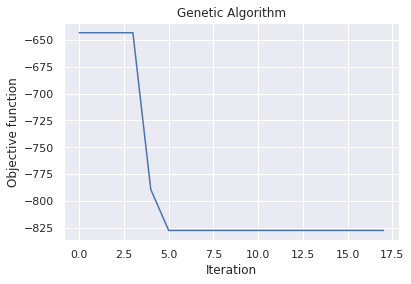


 The best solution found:                                                                           
 [ 33.04028578 114.86924664  85.06927954  67.04889407]

 Objective function:
 -851.9640502929688


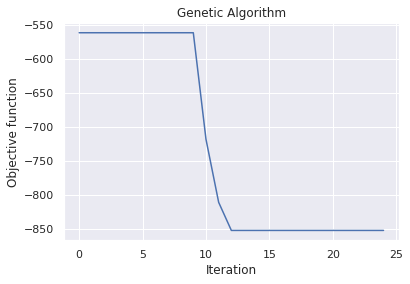


 The best solution found:                                                                           
 [ 19.49826823  29.65441761 102.28980825 114.75154341]

 Objective function:
 -1383.6937255859375


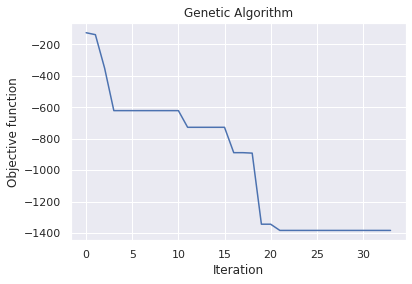


 The best solution found:                                                                           
 [28.89476308 52.29261466 97.87779931 74.68027072]

 Objective function:
 -1142.116943359375


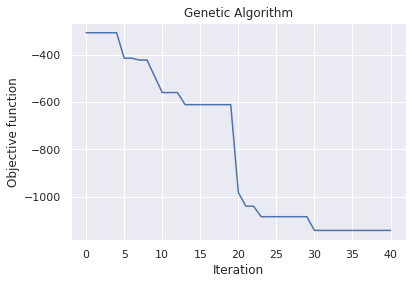

 The best solution found:                                                                           
 [40.2488365  51.82847601 97.7307661  77.73338911]

 Objective function:
 -1159.6693115234375


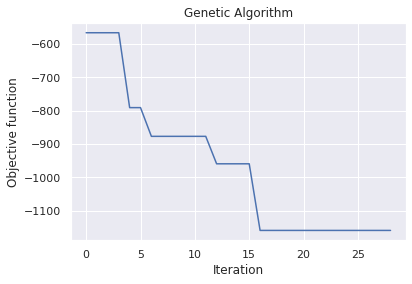


 The best solution found:                                                                           
 [ 36.2015897  114.96380311  51.09575618  42.84527429]

 Objective function:
 -853.2037963867188


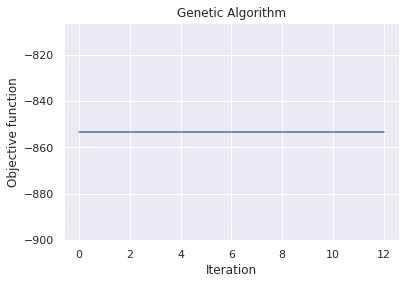


 The best solution found:                                                                           
 [ 21.50541546  49.0430398  102.39157236  74.89480882]

 Objective function:
 -1604.0179443359375


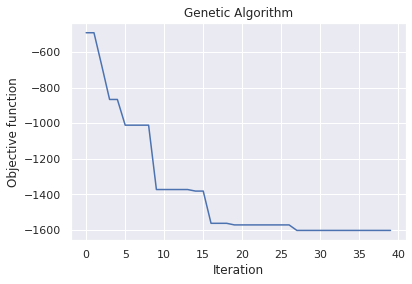


 The best solution found:                                                                           
 [27.58812936 51.8026006  87.12820582 82.82563605]

 Objective function:
 -1344.6534423828125


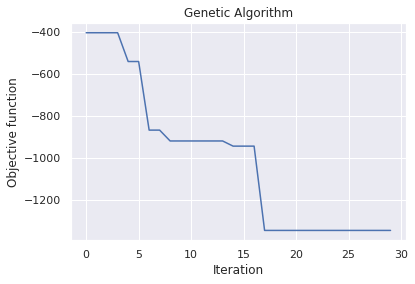


 The best solution found:                                                                           
 [24.05177379 48.45033638 84.48150325 74.61059956]

 Objective function:
 -1161.538818359375


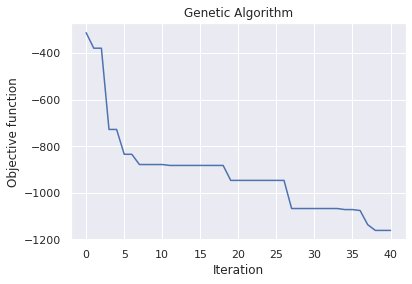

 The best solution found:                                                                           
 [ 33.95467643 160.8351684  126.31907116 121.33560553]

 Objective function:
 -1139.4114990234375


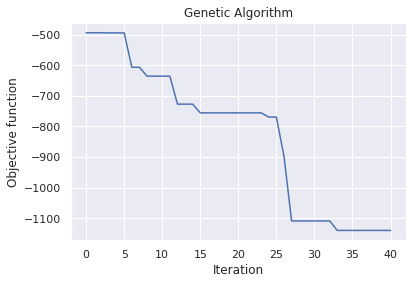

 The best solution found:                                                                           
 [ 26.08526629  58.83346212 127.51741738  78.43562052]

 Objective function:
 -1092.532958984375


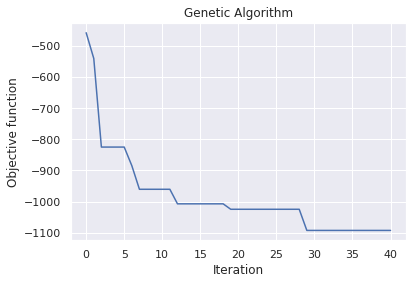

 The best solution found:                                                                           
 [ 25.95797774  26.62560834 101.97293882  53.36927609]

 Objective function:
 -1464.6583251953125


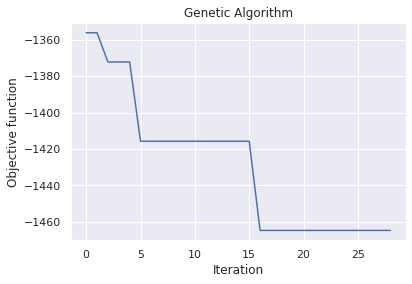


 The best solution found:                                                                           
 [ 14.34887231  34.46333952 101.61072366  76.72878643]

 Objective function:
 -1665.9635009765625


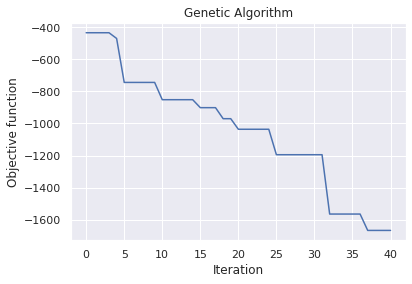

 The best solution found:                                                                           
 [38.58927123 47.84240204 97.13934806 75.47015036]

 Objective function:
 -1133.2315673828125


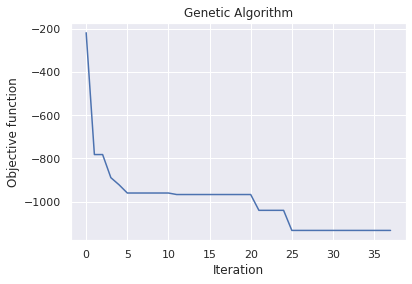


 The best solution found:                                                                           
 [ 20.60866514  50.77799011 102.9649922   73.24172446]

 Objective function:
 -1449.2806396484375


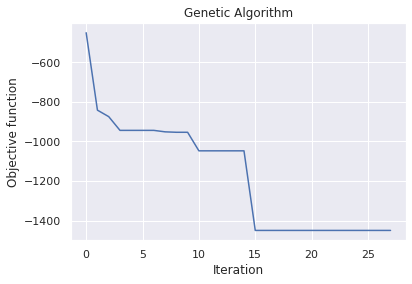


 The best solution found:                                                                           
 [ 39.83358938  49.58047742 128.39276483 102.42816904]

 Objective function:
 -1140.3902587890625


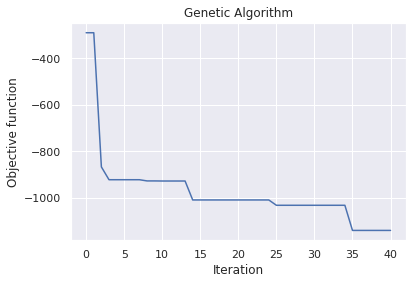

 The best solution found:                                                                           
 [ 33.1520092  115.82872592 142.90194528  76.90714677]

 Objective function:
 -958.4580688476562


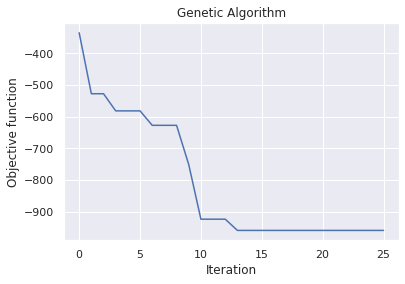


 The best solution found:                                                                           
 [ 42.55676446  36.51781369 128.44837534  75.31328251]

 Objective function:
 -1144.86279296875


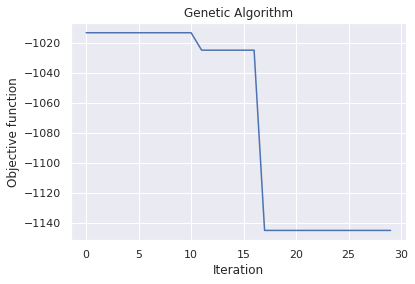


 The best solution found:                                                                           
 [ 18.93714909  57.08122496 102.38394824  76.9357588 ]

 Objective function:
 -1632.3685302734375


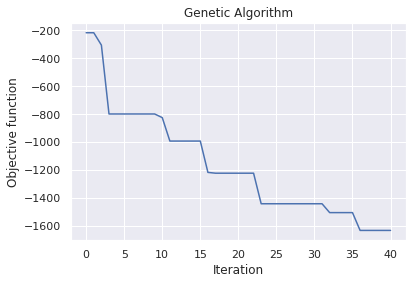

 The best solution found:                                                                           
 [45.15129946 36.90623456 65.26799084 77.4303147 ]

 Objective function:
 -1127.5567626953125


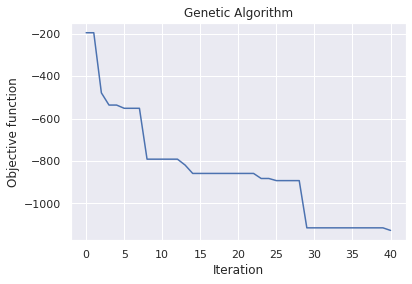

 The best solution found:                                                                           
 [27.6705193  27.81259493 44.31523887 37.64449253]

 Objective function:
 -884.8287963867188


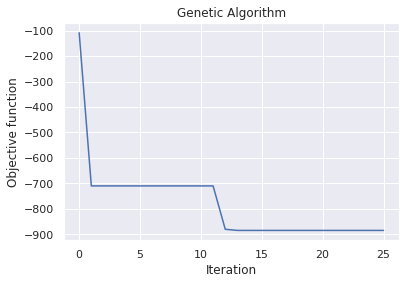


 The best solution found:                                                                           
 [ 24.28454584  48.59966267 102.63215714  74.73818245]

 Objective function:
 -1548.1119384765625


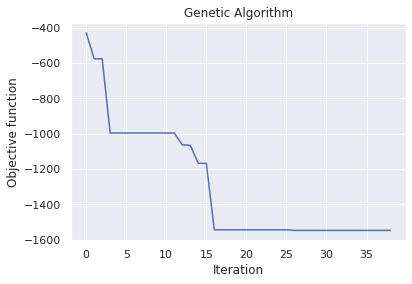


 The best solution found:                                                                           
 [ 38.72197419  50.67205773 103.63603762  93.23094155]

 Objective function:
 -1461.01171875


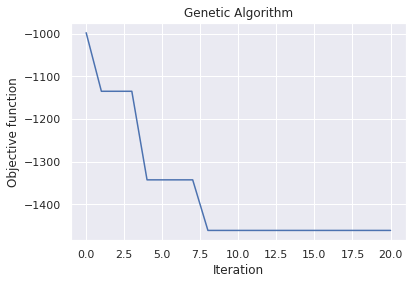


 The best solution found:                                                                           
 [38.92667897 51.15153748 63.66089137 96.39195141]

 Objective function:
 -1042.213134765625


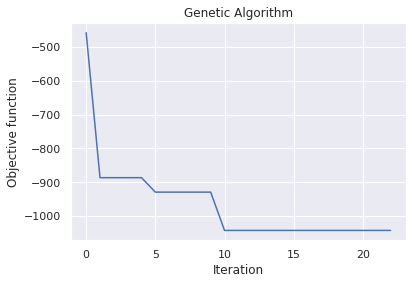


 The best solution found:                                                                           
 [ 37.49146592  47.07450997 103.62401064  83.59951953]

 Objective function:
 -1443.1107177734375


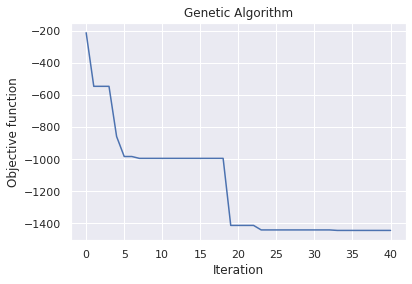

 The best solution found:                                                                           
 [ 42.77036064  43.28760262 102.07625485  85.18623424]

 Objective function:
 -1470.3765869140625


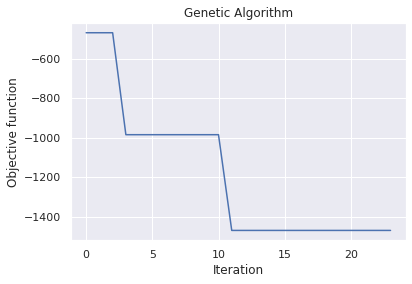


 The best solution found:                                                                           
 [ 39.50724929  55.78621548 138.45949936 113.30083319]

 Objective function:
 -1066.5179443359375


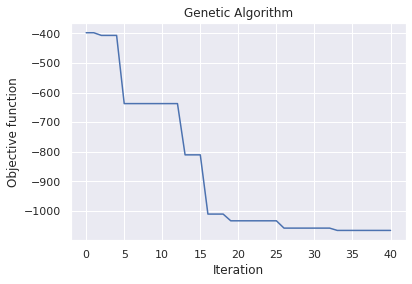

 The best solution found:                                                                           
 [ 11.08388104  48.72575144 101.32580772  76.74381887]

 Objective function:
 -1659.1690673828125


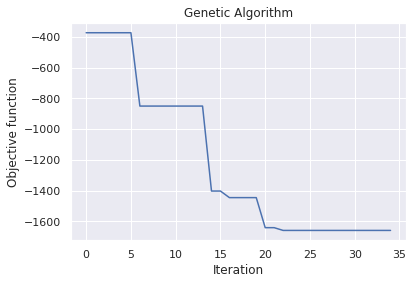


 The best solution found:                                                                           
 [21.34508059 48.10338574 86.45725058 44.10915974]

 Objective function:
 -1187.2353515625


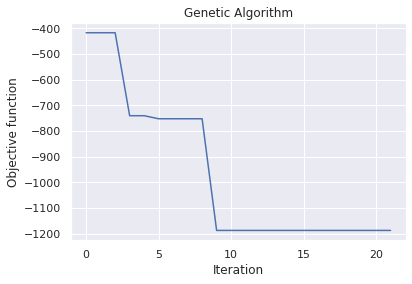


 The best solution found:                                                                           
 [41.70852923 51.68983341 45.14476994 78.91260333]

 Objective function:
 -1003.0811157226562


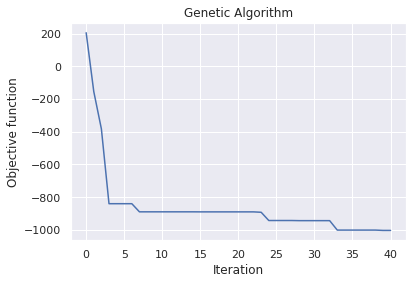

 The best solution found:                                                                           
 [25.53732605 58.26153323 85.4889347  82.81509847]

 Objective function:
 -1230.8740234375


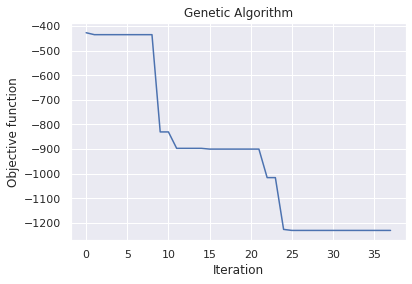


 The best solution found:                                                                           
 [ 21.56107012  50.90788754 104.88800077  76.43842755]

 Objective function:
 -1138.8602294921875


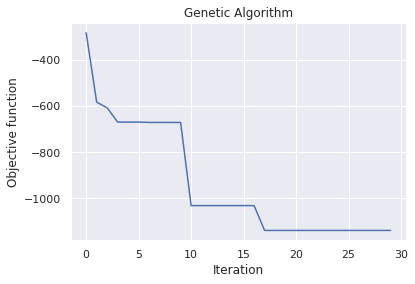


 The best solution found:                                                                           
 [42.91414981 48.53566549 87.50255205 75.26077251]

 Objective function:
 -1433.37890625


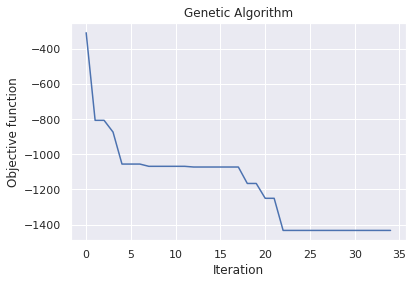


 The best solution found:                                                                           
 [17.00167246 51.2354074  63.81291747 77.38000625]

 Objective function:
 -1128.1815185546875


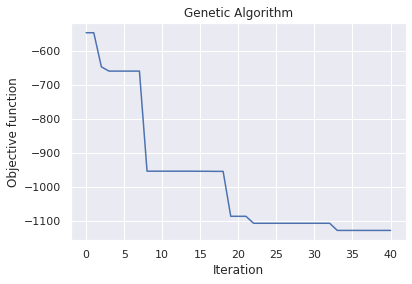

 The best solution found:                                                                           
 [  8.07646057  44.42009251 100.82271148 100.64949863]

 Objective function:
 -973.1550903320312


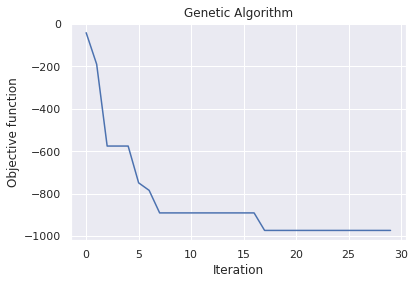


 The best solution found:                                                                           
 [14.90102858 36.38865489 84.58256193 57.91030245]

 Objective function:
 -976.3588256835938


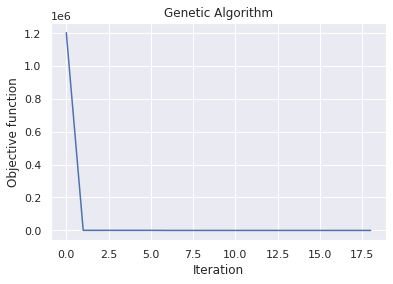


 The best solution found:                                                                           
 [ 21.88082189  29.47097875  97.50459118 126.27211175]

 Objective function:
 -793.4160766601562


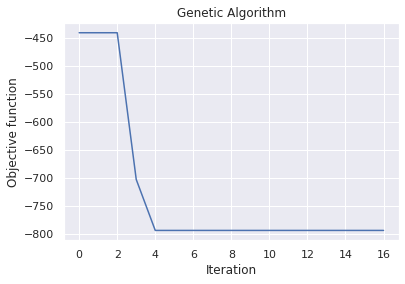


 The best solution found:                                                                           
 [ 28.72795147 116.03382229  55.51882528  58.67798177]

 Objective function:
 -707.9940795898438


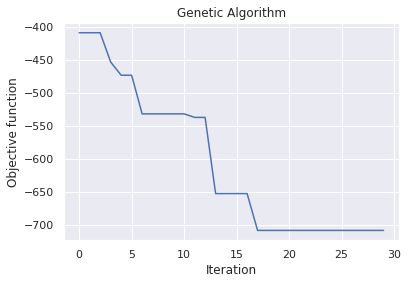


 The best solution found:                                                                           
 [38.05140065 29.09284232 80.24392887 46.07797405]

 Objective function:
 -979.6434936523438


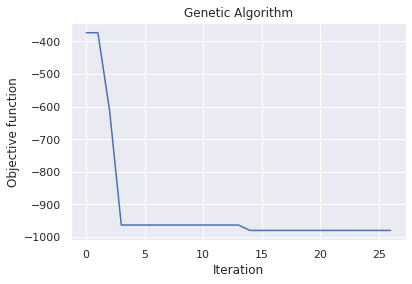


 The best solution found:                                                                           
 [ 18.6305789   27.59788459 102.99774521  76.66117933]

 Objective function:
 -1610.9217529296875


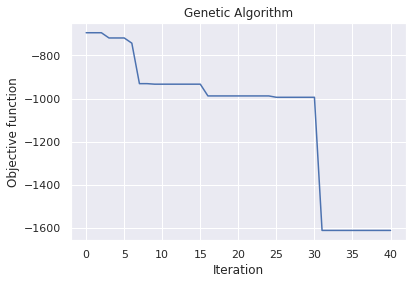

 The best solution found:                                                                           
 [ 17.66945182  36.67680087 102.39272842  76.89848912]

 Objective function:
 -1693.1802978515625


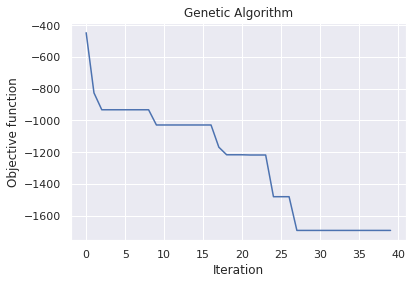


 The best solution found:                                                                           
 [ 30.79093142  85.27576964 138.98540774 106.27495375]

 Objective function:
 -938.3295288085938


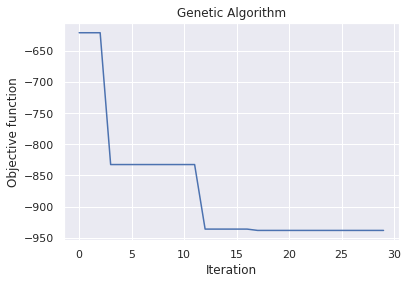


 The best solution found:                                                                           
 [19.98277162 54.17402335 85.71773795 43.47456716]

 Objective function:
 -1117.05029296875


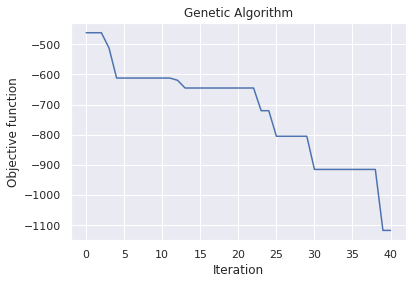

 The best solution found:                                                                           
 [ 43.22763999  58.94318448 143.48352796  50.95743991]

 Objective function:
 -572.3285522460938


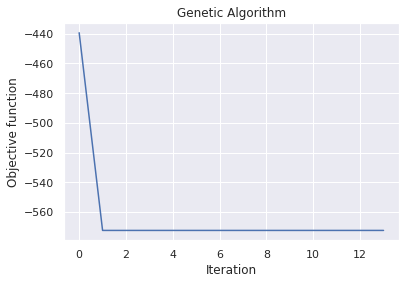


 The best solution found:                                                                           
 [25.15289314 47.21896864 97.67641626 75.54395576]

 Objective function:
 -1190.101318359375


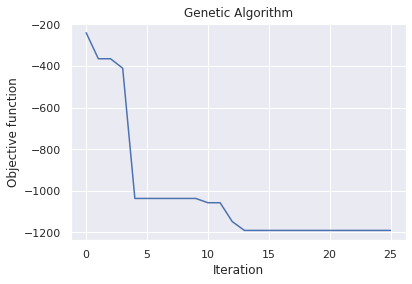


 The best solution found:                                                                           
 [39.02742253 57.03127883 91.70545733 74.7146528 ]

 Objective function:
 -1119.083740234375


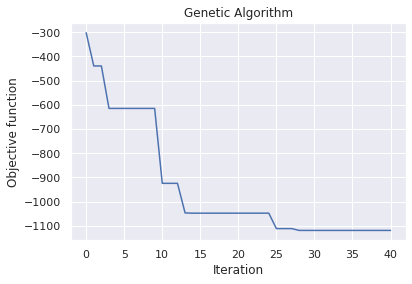


 The best solution found:                                                                           
 [19.78005102 50.9708637  77.84442012 76.14359917]

 Objective function:
 -1176.269287109375


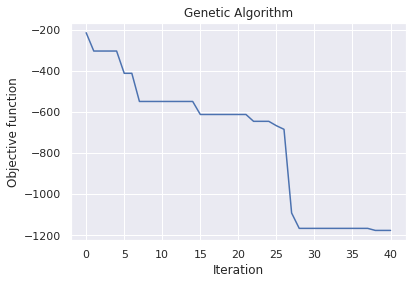

 The best solution found:                                                                           
 [ 31.36535034  46.58788733 128.83628002  76.8330824 ]

 Objective function:
 -1233.1544189453125


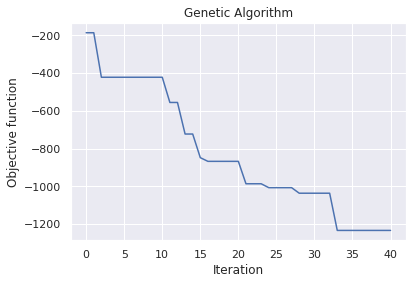

 The best solution found:                                                                           
 [ 34.57882944 112.67919827  85.49500566  77.21807945]

 Objective function:
 -1106.627685546875


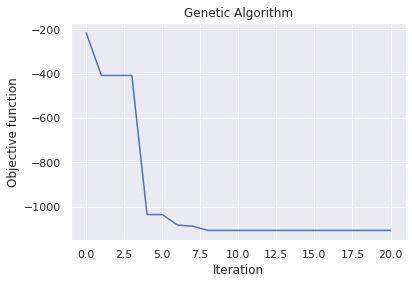


 The best solution found:                                                                           
 [ 27.22633623  47.25897289 100.48444668  76.86733545]

 Objective function:
 -1297.7017822265625


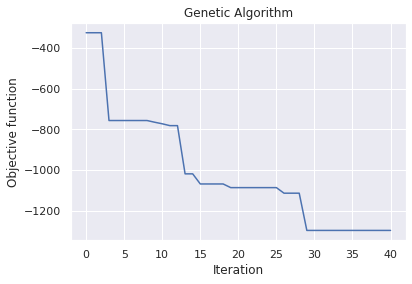

 The best solution found:                                                                           
 [ 40.7053134   47.71024994 127.01859132 103.75620294]

 Objective function:
 -1131.9854736328125


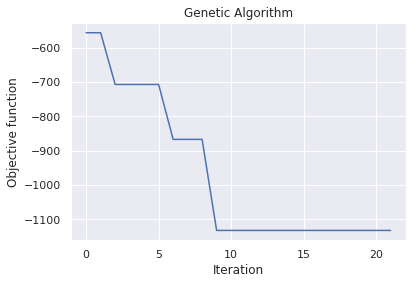


 The best solution found:                                                                           
 [ 32.48343204  36.4750173  102.33281094  78.23319068]

 Objective function:
 -1565.9986572265625


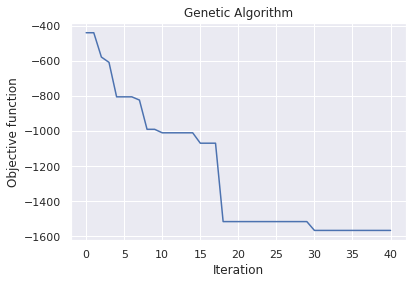

 The best solution found:                                                                           
 [ 31.26460862  56.30845502 103.1390651  107.06457321]

 Objective function:
 -1350.054443359375


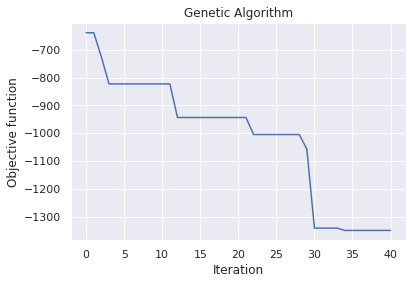

 The best solution found:                                                                           
 [ 33.60249559  32.9200528  102.54824725  77.24451346]

 Objective function:
 -1626.6512451171875


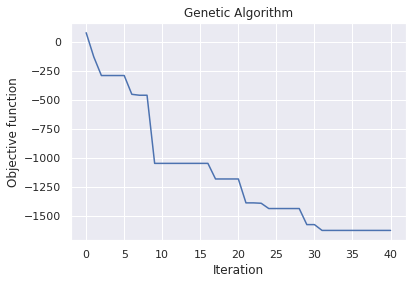

 The best solution found:                                                                           
 [ 24.8812444   50.01362003 102.30470517 123.79130709]

 Objective function:
 -1411.794921875


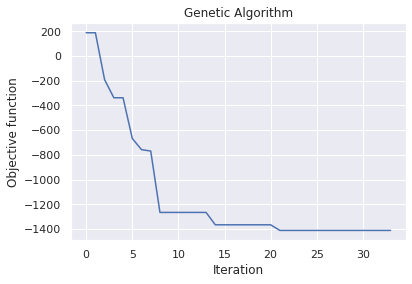


 The best solution found:                                                                           
 [37.63537196 34.71324415 56.23094824 93.17270373]

 Objective function:
 -990.5537719726562


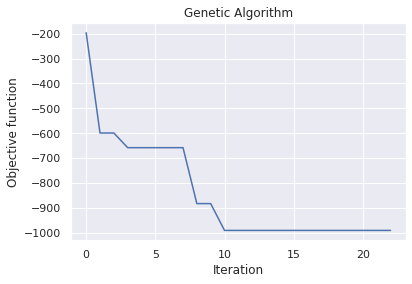


 The best solution found:                                                                           
 [34.30709102 36.21920927 85.20003423 81.41172764]

 Objective function:
 -1280.5030517578125


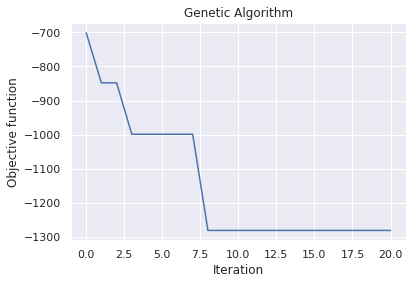


 The best solution found:                                                                           
 [ 31.25964134  25.49811212 101.50103577  55.06723919]

 Objective function:
 -1460.802490234375


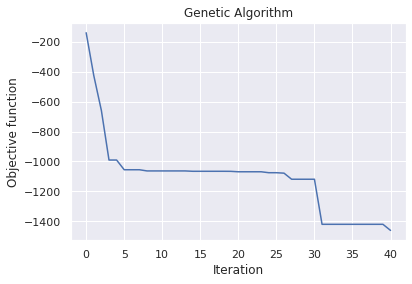

 The best solution found:                                                                           
 [ 18.41956512  13.90386096 102.38021534  77.42146832]

 Objective function:
 -1197.438720703125


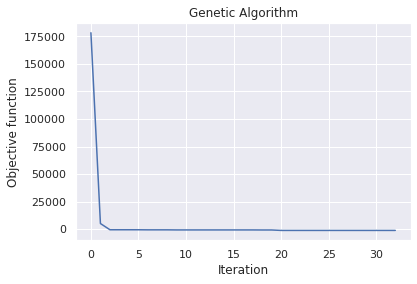


 The best solution found:                                                                           
 [ 32.02316971  51.64610954 101.47839529  77.99467707]

 Objective function:
 -1528.613037109375


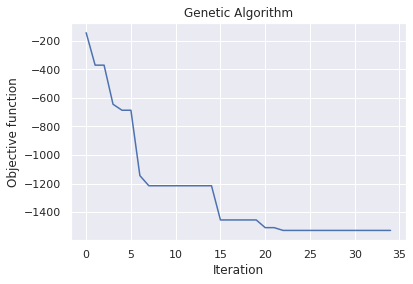


 The best solution found:                                                                           
 [ 27.36132721  42.76725092  82.59213916 106.17417047]

 Objective function:
 -1036.0108642578125


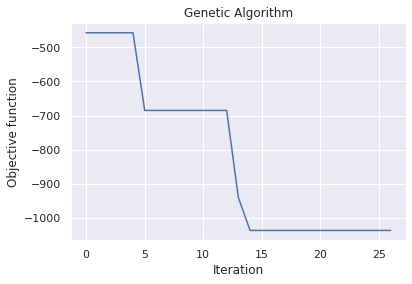


 The best solution found:                                                                           
 [ 43.32585347  84.71711323  88.39603926 121.78553077]

 Objective function:
 -970.4601440429688


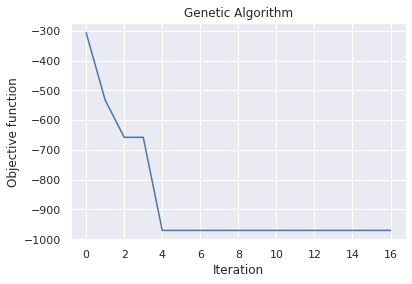


 The best solution found:                                                                           
 [22.92723328 28.71653379 87.23605889 60.29602559]

 Objective function:
 -1115.885009765625


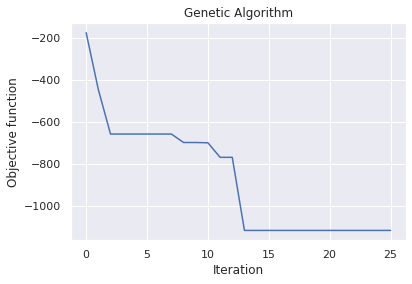


 The best solution found:                                                                           
 [ 25.8454088   48.48709814 106.74596976 112.13501452]

 Objective function:
 -886.5160522460938


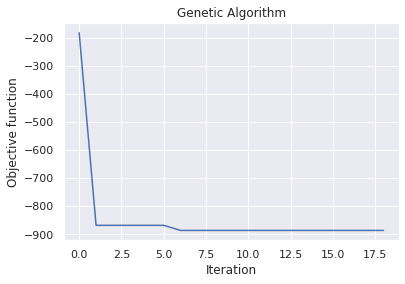


 The best solution found:                                                                           
 [ 14.1563084   26.88360715 102.40662274 104.5060257 ]

 Objective function:
 -1472.76904296875


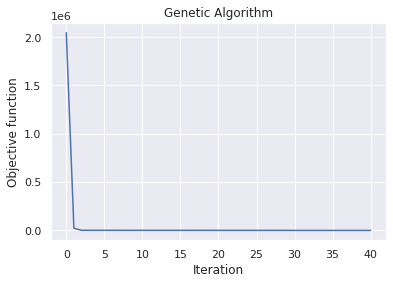

 The best solution found:                                                                           
 [ 15.0083294   49.25675057  86.48880755 103.580775  ]

 Objective function:
 -1294.950439453125


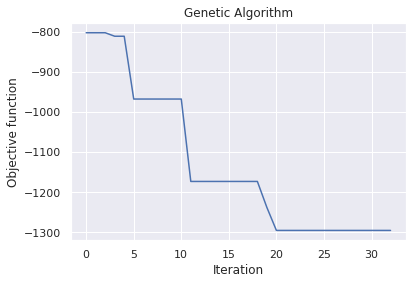


 The best solution found:                                                                           
 [23.24012547 27.33038252 66.28884762 47.84052942]

 Objective function:
 -937.0239868164062


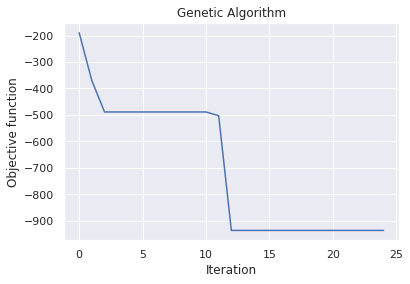


 The best solution found:                                                                           
 [ 33.15915855  19.48393351  86.3465173  113.27606535]

 Objective function:
 -962.0686645507812


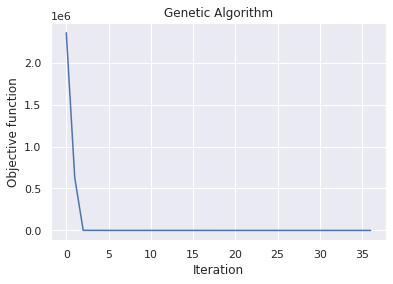


 The best solution found:                                                                           
 [ 31.09962761  34.44052555 101.71139403 112.57047541]

 Objective function:
 -1455.744873046875


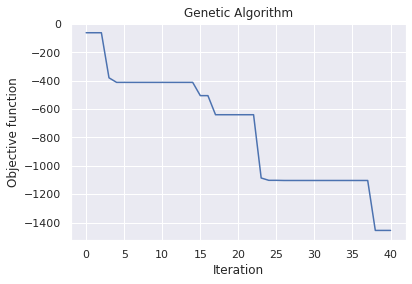

 The best solution found:                                                                           
 [ 20.83205007 151.6479386  102.11128352  76.60670688]

 Objective function:
 -1235.239013671875


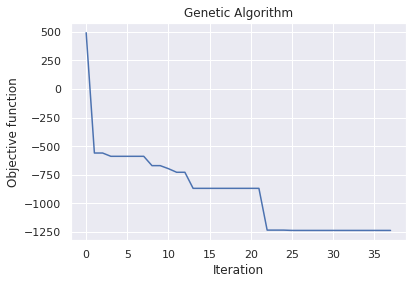


 The best solution found:                                                                           
 [ 14.25233224  15.45861851 102.12357987  93.71680502]

 Objective function:
 -1082.7149658203125


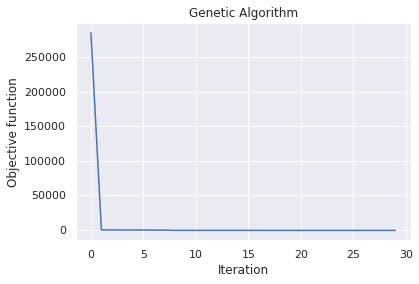


 The best solution found:                                                                           
 [ 19.89821873  94.55356315  86.46106154 124.72887115]

 Objective function:
 -1014.8173217773438


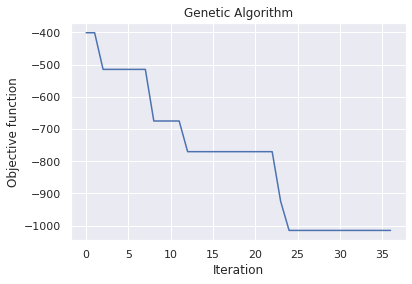


 The best solution found:                                                                           
 [  8.75190952  47.61872577 127.02903081 111.27901602]

 Objective function:
 -1091.2181396484375


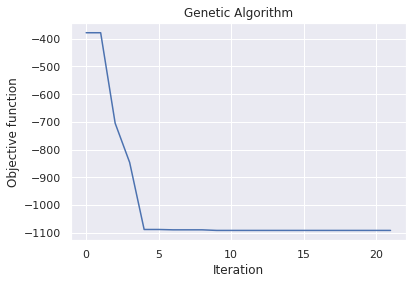


 The best solution found:                                                                           
 [ 9.17519343 55.66687159 87.4201747  75.04853566]

 Objective function:
 -1375.25634765625


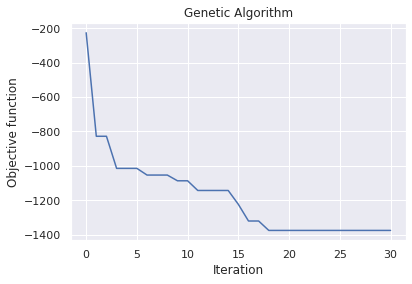


 The best solution found:                                                                           
 [ 45.51063468  49.33714241 102.86127815  85.1446032 ]

 Objective function:
 -1447.4803466796875


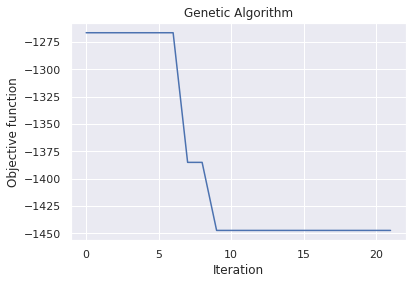


 The best solution found:                                                                           
 [  8.81844095  49.82386342 103.71223106  99.28483623]

 Objective function:
 -1392.8154296875


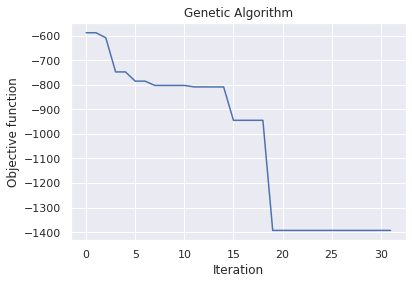


 The best solution found:                                                                           
 [14.59726969 27.61990798 60.4151953  46.71568392]

 Objective function:
 -945.9191284179688


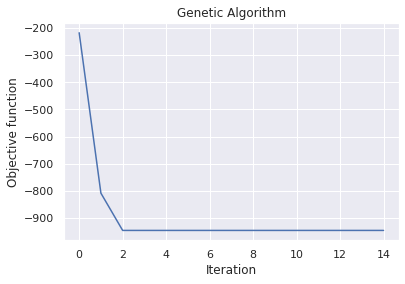


 The best solution found:                                                                           
 [ 14.81986171 161.0321068  103.41089863  68.607011  ]

 Objective function:
 -853.2280883789062


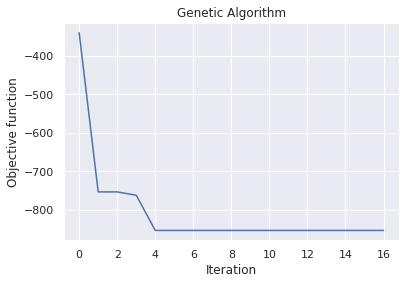


 The best solution found:                                                                           
 [ 32.54833556 159.20829933 128.90112359  54.46021434]

 Objective function:
 -824.6325073242188


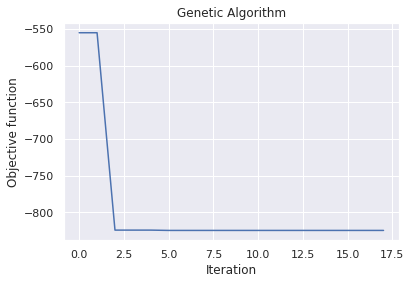


 The best solution found:                                                                           
 [11.73896186 51.89296532 85.9120104  84.85828011]

 Objective function:
 -1327.3173828125


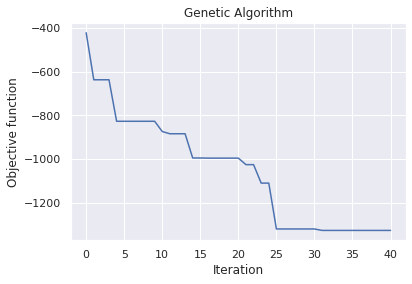

 The best solution found:                                                                           
 [ 30.65863548  52.00914973 103.41265024  96.50111694]

 Objective function:
 -1508.39599609375


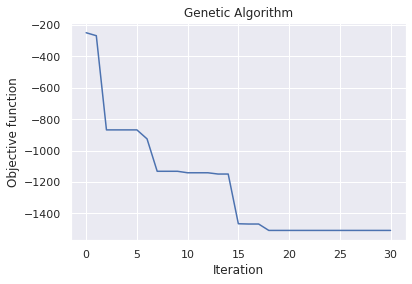


 The best solution found:                                                                           
 [ 20.00883776  51.73341804 140.07347114 111.92830777]

 Objective function:
 -1085.1138916015625


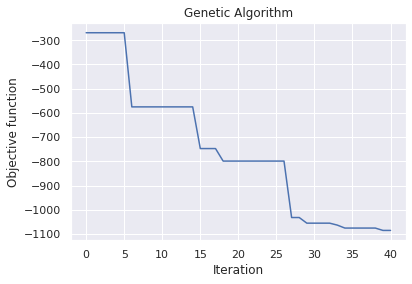

 The best solution found:                                                                           
 [35.70088444 38.93610152 85.69793025 71.53714501]

 Objective function:
 -1272.7918701171875


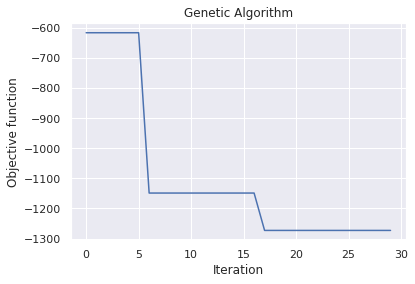


 The best solution found:                                                                           
 [17.64343041 51.33028999 83.07836662 76.5850849 ]

 Objective function:
 -1286.0704345703125


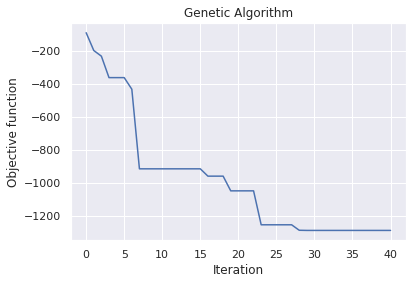

 The best solution found:                                                                           
 [ 14.04751631 163.15842105 101.61808586 124.91038306]

 Objective function:
 -1018.9880981445312


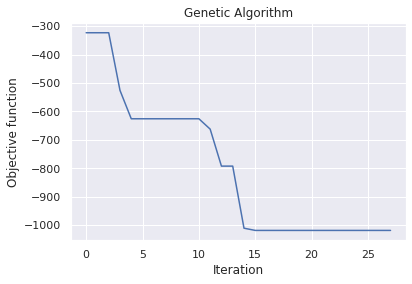


 The best solution found:                                                                           
 [ 12.67519161  41.05469162 102.47776632  76.19515126]

 Objective function:
 -1716.3304443359375


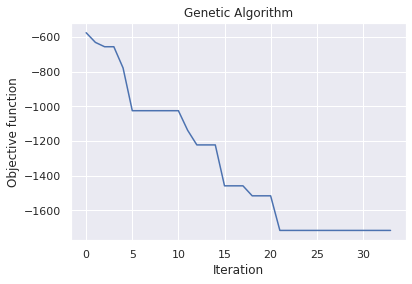


 The best solution found:                                                                           
 [ 29.03148096  48.16014612 102.46887563  80.52633632]

 Objective function:
 -1523.7811279296875


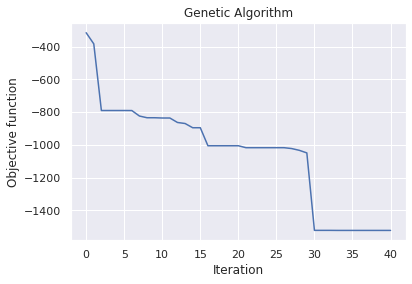

 The best solution found:                                                                           
 [ 43.84187219  27.7721314  101.17560736  77.84023547]

 Objective function:
 -1503.74560546875


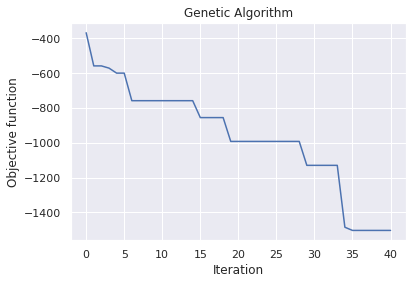

 The best solution found:                                                                           
 [ 39.03960783  48.39490163 135.78069447 113.35051566]

 Objective function:
 -1061.6324462890625


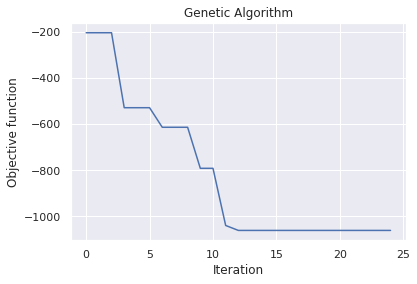


 The best solution found:                                                                           
 [ 29.48956657  58.03018921 102.36058238  84.57041395]

 Objective function:
 -1437.371337890625


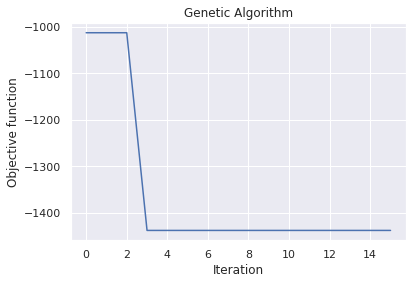


 The best solution found:                                                                           
 [ 45.52724323  50.14566417  82.01291951 124.38164305]

 Objective function:
 -1024.99560546875


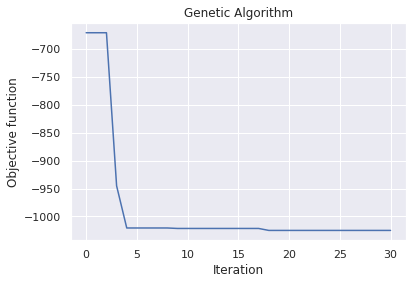


 The best solution found:                                                                           
 [ 18.16027044  35.59762632 101.98360902 112.30813186]

 Objective function:
 -1463.7672119140625


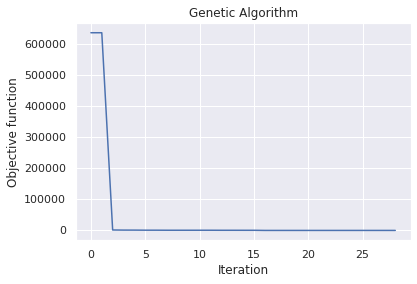


 The best solution found:                                                                           
 [ 42.6012474  138.52772066  86.56160332 126.33905031]

 Objective function:
 -1105.0543212890625


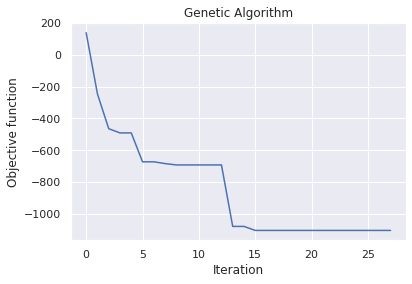


 The best solution found:                                                                           
 [ 30.82746258  27.76193077  87.04590205 104.65003205]

 Objective function:
 -1245.144287109375


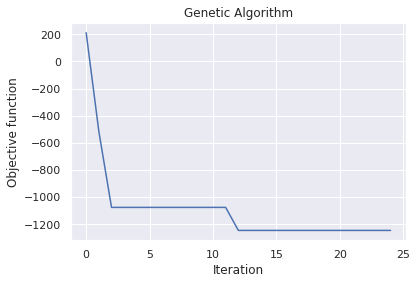


 The best solution found:                                                                           
 [ 38.53075463 153.08902739 103.1660446  212.86810472]

 Objective function:
 -748.5850219726562


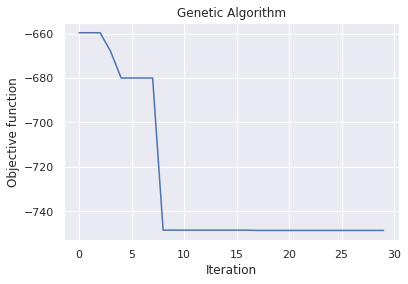


 The best solution found:                                                                           
 [ 39.47748936  26.09622495  87.31677766 113.66602192]

 Objective function:
 -1202.5718994140625


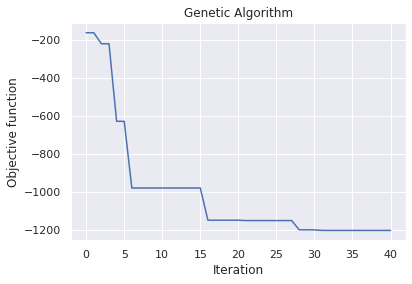

 The best solution found:                                                                           
 [22.01418386  3.59206754 45.55823277 78.62356241]

 Objective function:
 -731.1665649414062


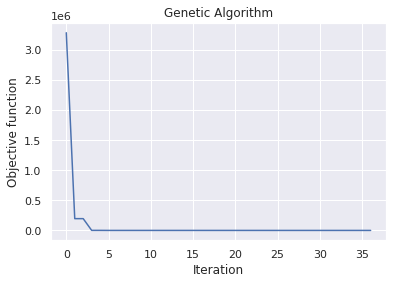


 The best solution found:                                                                           
 [16.99002686 35.09650391 82.94528275 82.61725104]

 Objective function:
 -1112.5928955078125


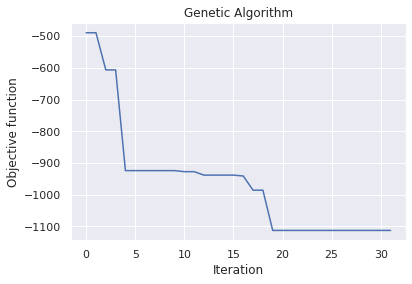


 The best solution found:                                                                           
 [ 20.99740696 138.78277241 100.52820354 124.90168127]

 Objective function:
 -925.1122436523438


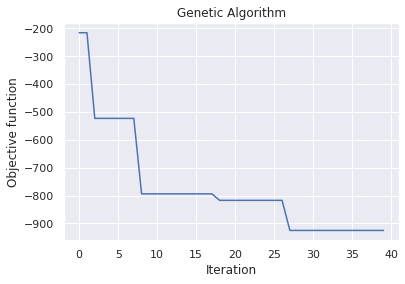


 The best solution found:                                                                           
 [19.21916888 25.59904349 89.56363606 76.3379162 ]

 Objective function:
 -1221.787841796875


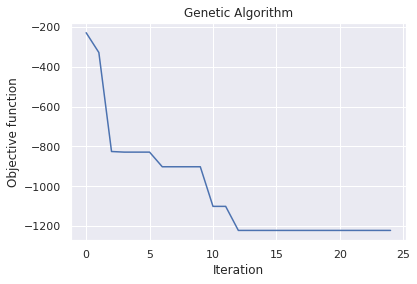


 The best solution found:                                                                           
 [18.23722974 26.28592059 86.77193035 77.13646993]

 Objective function:
 -1496.284423828125


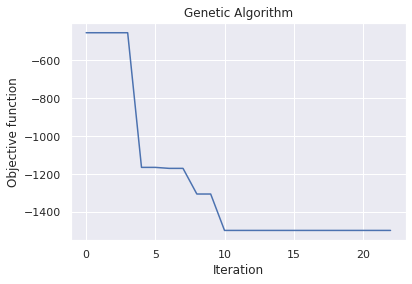


 The best solution found:                                                                           
 [33.85115368 37.29487457 83.26756395 57.30713252]

 Objective function:
 -946.0801391601562


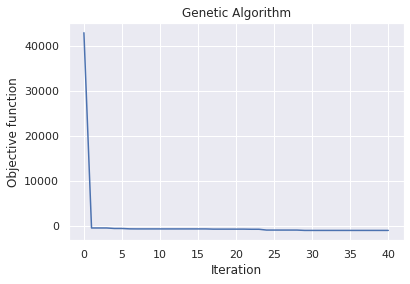

 The best solution found:                                                                           
 [ 21.54366891  41.52721852  86.09040418 103.93814574]

 Objective function:
 -1280.7674560546875


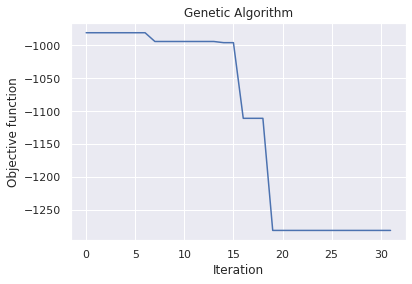


 The best solution found:                                                                           
 [ 20.62886892  36.35332082 114.62323484 102.47821981]

 Objective function:
 -1105.4449462890625


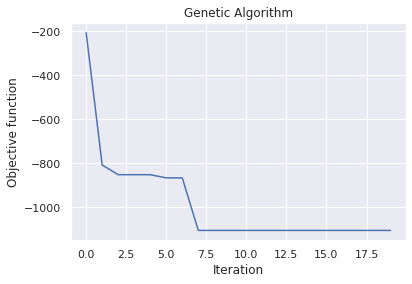


 The best solution found:                                                                           
 [ 26.99796144  46.46074199 101.74371895  95.67203471]

 Objective function:
 -1510.3546142578125


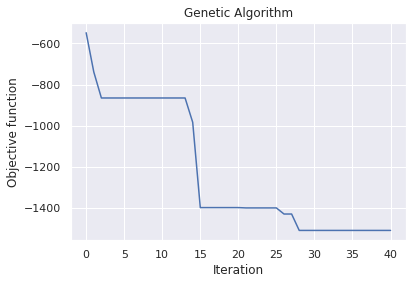


 The best solution found:                                                                           
 [ 31.69623686  84.64199381 102.3582522   94.86189816]

 Objective function:
 -1269.205810546875


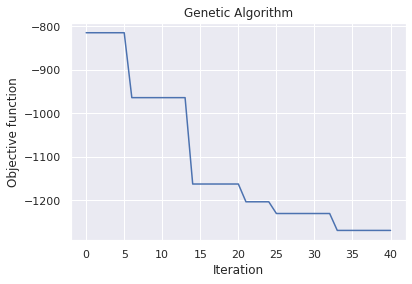

 The best solution found:                                                                           
 [15.36926003 37.22873553 89.77243105 76.27892017]

 Objective function:
 -1247.755615234375


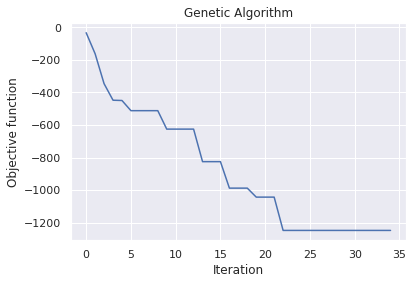


 The best solution found:                                                                           
 [ 22.14014615  44.03295863 103.62155501  76.99670969]

 Objective function:
 -1634.8402099609375


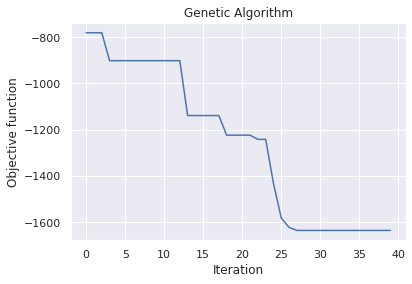


 The best solution found:                                                                           
 [ 12.75751924  49.83774549 102.28389852  78.47218067]

 Objective function:
 -1566.4073486328125


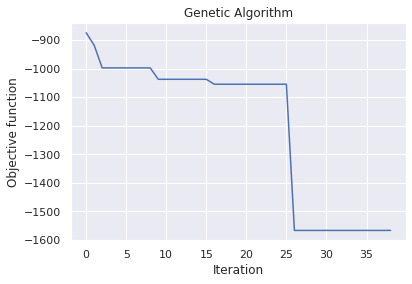


 The best solution found:                                                                           
 [ 20.61223069  43.45459466  90.6832735  102.33514248]

 Objective function:
 -1030.53564453125


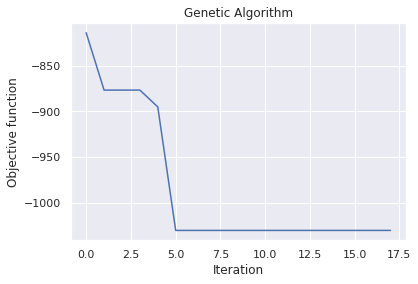


 The best solution found:                                                                           
 [ 18.8827712   42.8341677  103.06681474  94.33069353]

 Objective function:
 -1494.506591796875


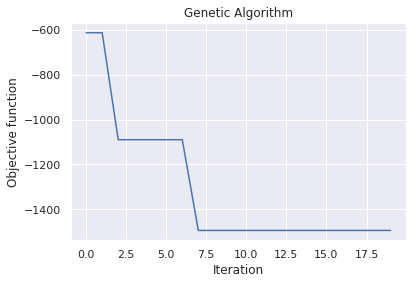


 The best solution found:                                                                           
 [ 26.06483653  27.72035165 102.27286378  76.21154677]

 Objective function:
 -1660.7135009765625


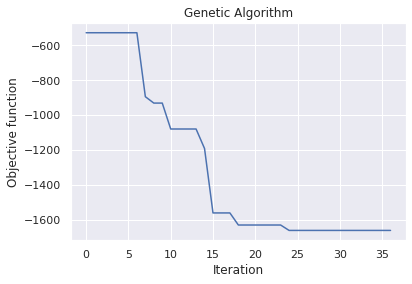


 The best solution found:                                                                           
 [ 35.75609847  36.97885603  85.48066572 104.42769742]

 Objective function:
 -1257.400634765625


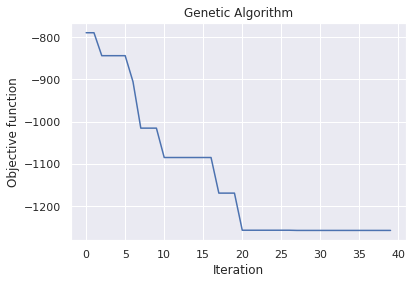


 The best solution found:                                                                           
 [24.7302335  52.89836508 86.3708638  77.3221442 ]

 Objective function:
 -1459.462646484375


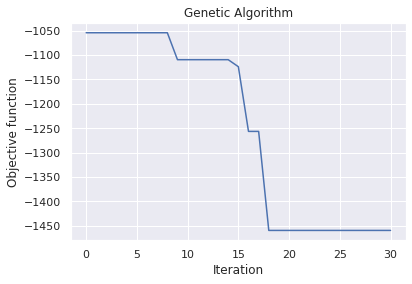


 The best solution found:                                                                           
 [ 28.11531002  46.79516372 103.7203703  104.70786207]

 Objective function:
 -1473.4150390625


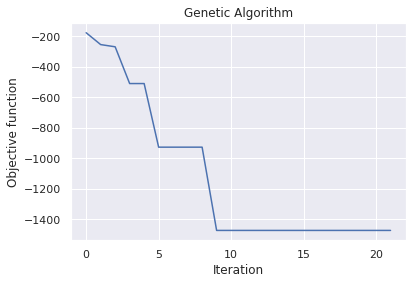


 The best solution found:                                                                           
 [ 39.04684371  56.90463624 102.61749212 104.4546738 ]

 Objective function:
 -1419.8291015625


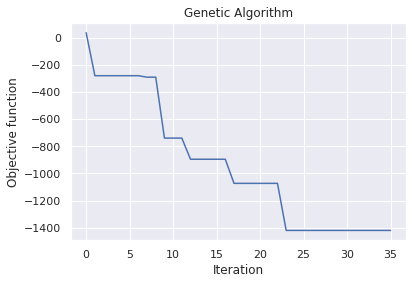


 The best solution found:                                                                           
 [ 36.3417956   58.66693663 102.37189565 113.13802831]

 Objective function:
 -1443.193603515625


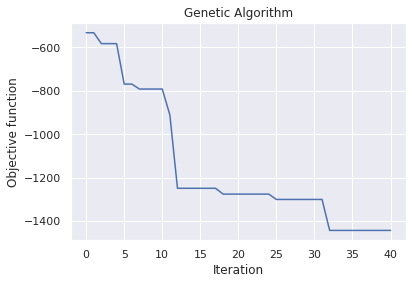

 The best solution found:                                                                           
 [32.18787625 35.57786056 87.02178528 82.24339452]

 Objective function:
 -1339.585205078125


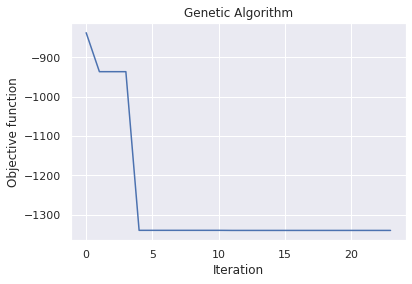


 The best solution found:                                                                           
 [ 38.3381159   35.63030214 102.49663888  77.22396931]

 Objective function:
 -1729.6287841796875


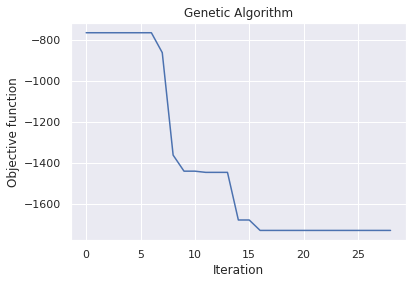


 The best solution found:                                                                           
 [31.60449307 37.23676047 87.06931575 47.07947708]

 Objective function:
 -1219.6611328125


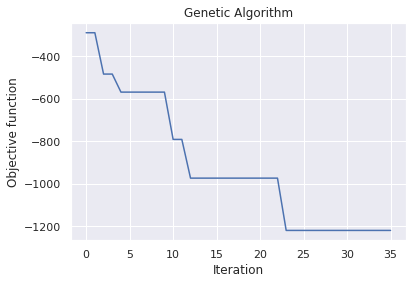


 The best solution found:                                                                           
 [  8.81909286  57.95881841 134.60455318 112.80689115]

 Objective function:
 -1065.1885986328125


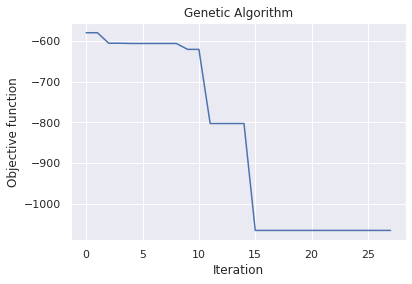


 The best solution found:                                                                           
 [25.58972847 51.75802849 86.94488699 83.51865244]

 Objective function:
 -1340.2548828125


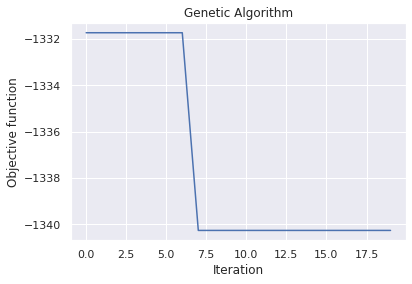


 The best solution found:                                                                           
 [31.75681948 49.90257287 86.00415494 74.16499099]

 Objective function:
 -1327.1065673828125


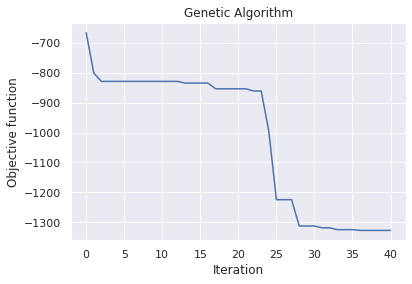

 The best solution found:                                                                           
 [ 36.88125699  46.61689666 102.25591246  87.351173  ]

 Objective function:
 -1458.060302734375


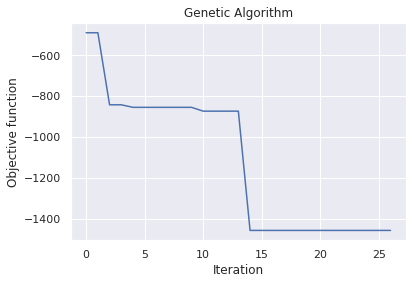


 The best solution found:                                                                           
 [ 29.06691163  41.80594942 134.83087488 112.84584741]

 Objective function:
 -1070.919677734375


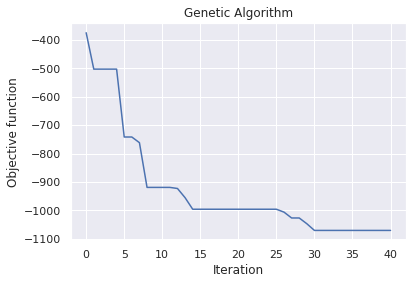

 The best solution found:                                                                           
 [25.06820868 52.82156111 86.78064621 77.30746166]

 Objective function:
 -1469.6058349609375


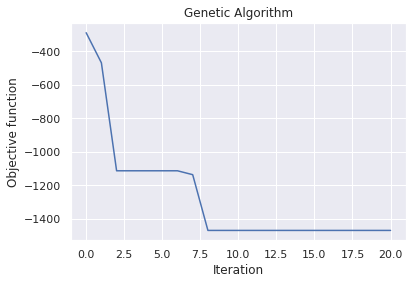


 The best solution found:                                                                           
 [10.28598989 29.21059175 81.4909097  75.35719903]

 Objective function:
 -1126.9208984375


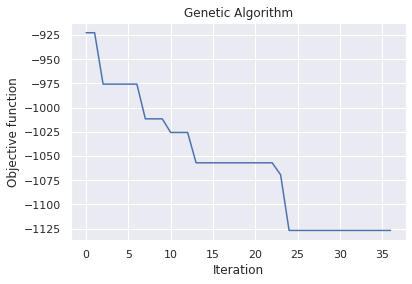


 The best solution found:                                                                           
 [ 22.41614222  42.49585393 103.10680272  77.31891529]

 Objective function:
 -1627.3209228515625


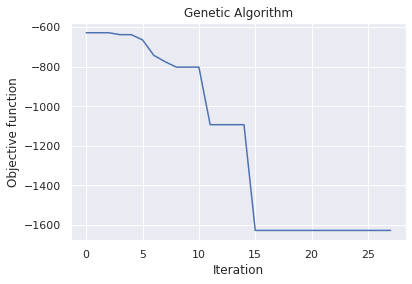


 The best solution found:                                                                           
 [ 42.94171405  57.13613842 102.42636318  79.82813169]

 Objective function:
 -1478.547607421875


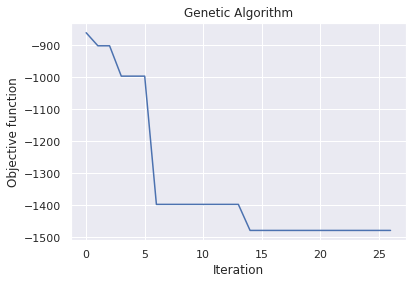


 The best solution found:                                                                           
 [ 41.57485401  44.71039028 102.8999653   96.37885331]

 Objective function:
 -1505.2723388671875


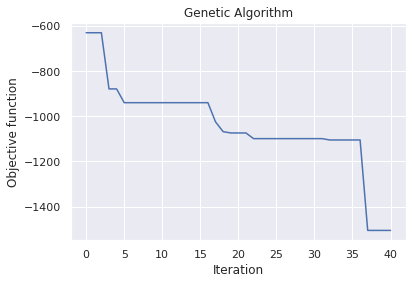

 The best solution found:                                                                           
 [ 27.87396705  38.63492834 101.28341322  77.79746203]

 Objective function:
 -1512.994873046875


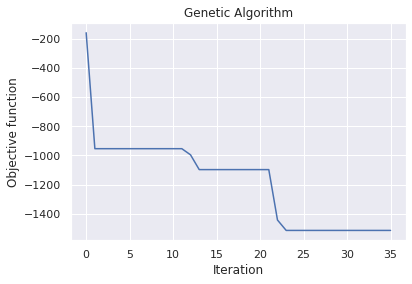


 The best solution found:                                                                           
 [19.92962622 53.75140882 17.85057482 95.03401765]

 Objective function:
 -911.0132446289062


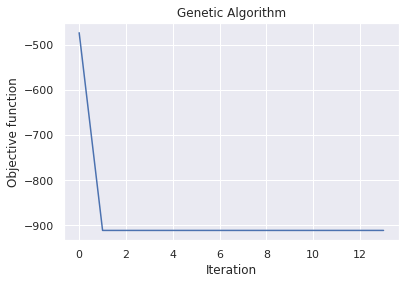


 The best solution found:                                                                           
 [26.95281136 49.72757085 41.63583177 96.26142174]

 Objective function:
 -1032.1790771484375


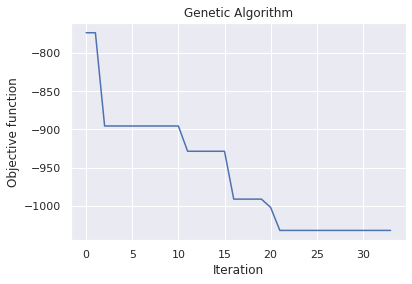


 The best solution found:                                                                           
 [26.1173108  48.72882631 86.0004252  77.39596595]

 Objective function:
 -1517.1256103515625


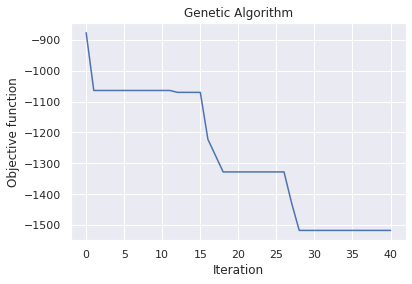


 The best solution found:                                                                           
 [31.54584114 48.10250428 86.19087442 78.80051504]

 Objective function:
 -1386.6893310546875


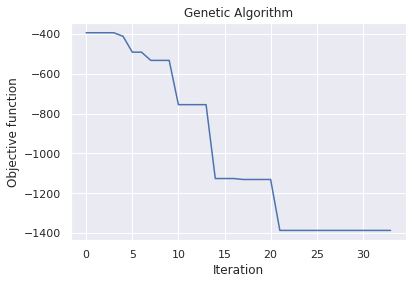


 The best solution found:                                                                           
 [ 26.50597527  50.56577884 102.47718321  95.53685985]

 Objective function:
 -1588.8248291015625


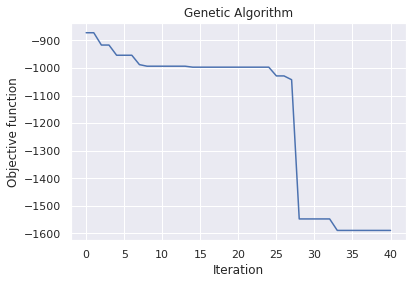

 The best solution found:                                                                           
 [ 27.97079811  30.18764554 101.79629421  86.01613175]

 Objective function:
 -1369.5982666015625


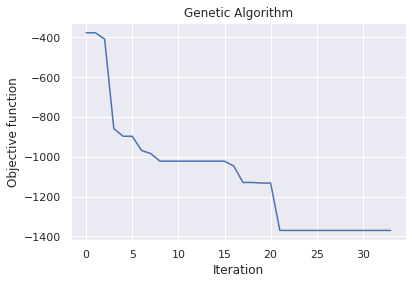


 The best solution found:                                                                           
 [ 41.76611871  28.59657835 102.92309173  78.32360166]

 Objective function:
 -1485.5833740234375


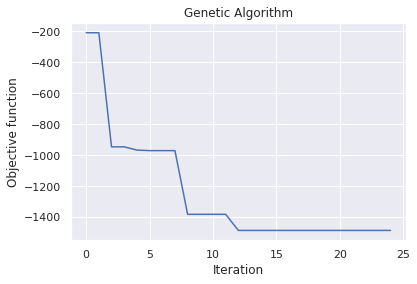


 The best solution found:                                                                           
 [ 22.29378984 274.16434187 255.06955593  70.7564105 ]

 Objective function:
 163316.734375


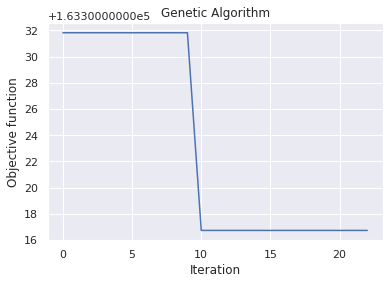


 The best solution found:                                                                           
 [ 45.91875146  53.2537125   87.25432562 104.95697388]

 Objective function:
 -1260.421142578125


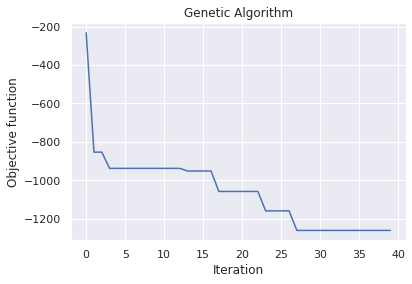


 The best solution found:                                                                           
 [22.06950103 49.98673962 97.87438327 56.91696187]

 Objective function:
 -1036.6461181640625


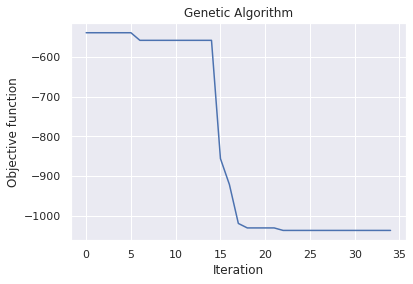


 The best solution found:                                                                           
 [16.928602   25.75527652 85.15339332 80.82269932]

 Objective function:
 -1232.8232421875


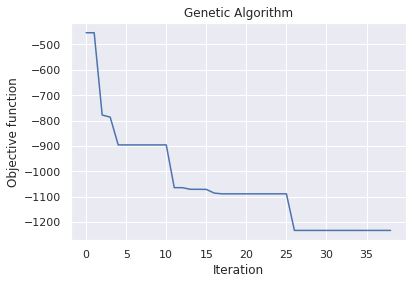


 The best solution found:                                                                           
 [ 26.38658475  52.0102615  102.44016501 122.34954132]

 Objective function:
 -1453.6114501953125


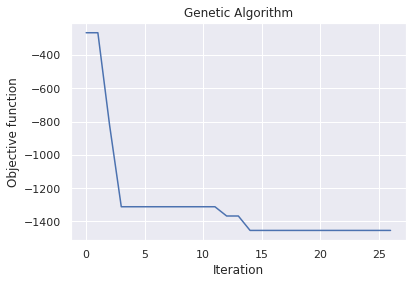


 The best solution found:                                                                           
 [ 21.20913985  38.69867091 102.03209981  54.86024604]

 Objective function:
 -1390.9451904296875


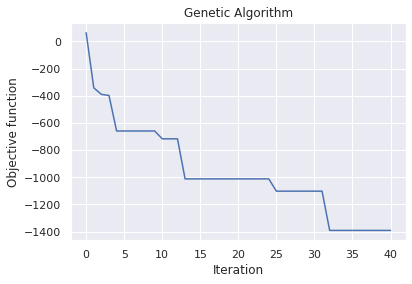

 The best solution found:                                                                           
 [ 28.61581638  26.90301468  87.83456186 118.27315926]

 Objective function:
 -857.4166870117188


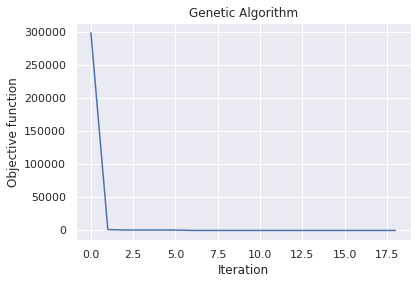


 The best solution found:                                                                           
 [ 19.83892382   6.76937223 101.76764472  44.77047366]

 Objective function:
 -1020.2034301757812


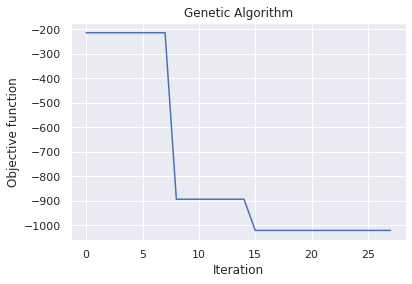


 The best solution found:                                                                           
 [ 40.88764663  44.1142408   86.27438808 126.61251755]

 Objective function:
 -1115.0849609375


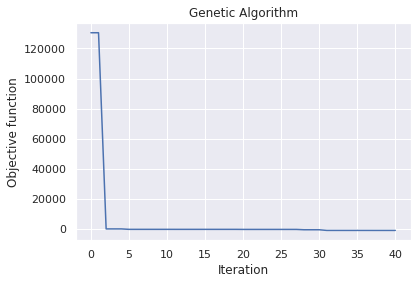

 The best solution found:                                                                           
 [39.67741011 25.46480638 98.25459918 73.74107738]

 Objective function:
 -1066.4566650390625


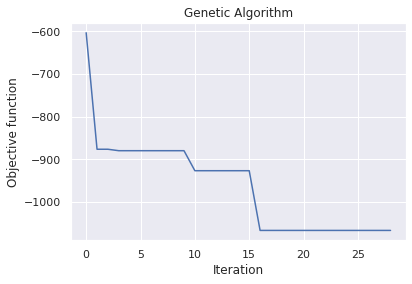


 The best solution found:                                                                           
 [18.78008921 49.29222689 85.99332031 74.62303533]

 Objective function:
 -1433.935791015625


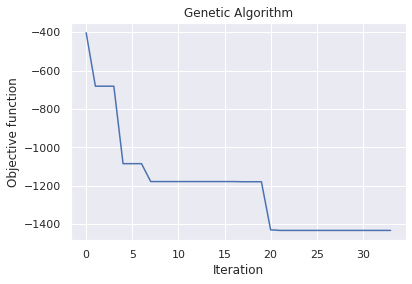


 The best solution found:                                                                           
 [18.53974962 55.05708388 86.62578345 79.68657787]

 Objective function:
 -1283.0916748046875


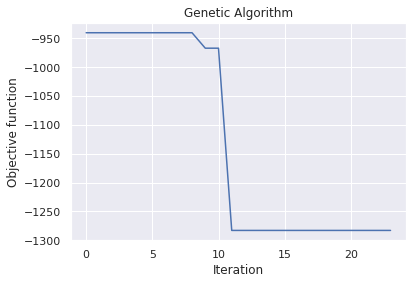


 The best solution found:                                                                           
 [ 16.76506859  31.8396797   85.66409868 126.00178046]

 Objective function:
 -1048.06005859375


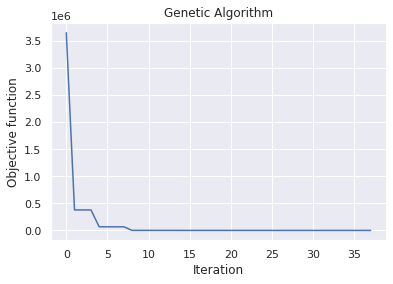


 The best solution found:                                                                           
 [28.96176372 35.3724154  86.06192576 89.63226426]

 Objective function:
 -1297.979248046875


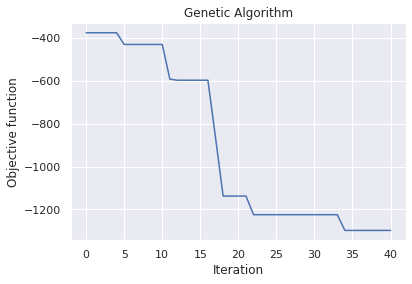

 The best solution found:                                                                           
 [ 27.08977824  46.07194393 114.63766803 104.50812374]

 Objective function:
 -1106.2403564453125


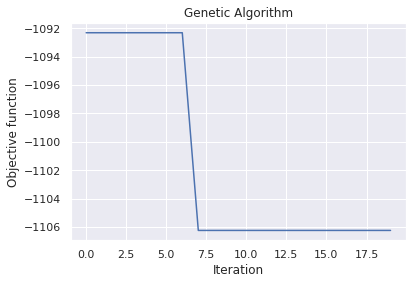


 The best solution found:                                                                           
 [ 30.10984351  86.52696156 128.62789451 105.00317071]

 Objective function:
 -996.3707885742188


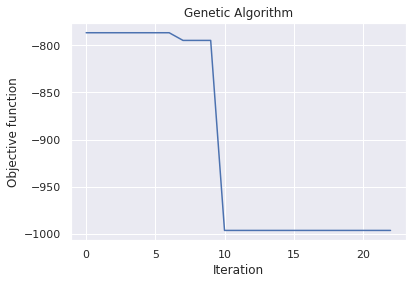


 The best solution found:                                                                           
 [41.25283824 48.65958    83.78401147 76.02567429]

 Objective function:
 -1135.6920166015625


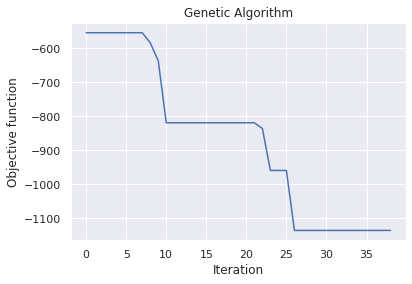


 The best solution found:                                                                           
 [ 12.38678438  36.17803872 101.02436848 105.46399269]

 Objective function:
 -1113.7962646484375


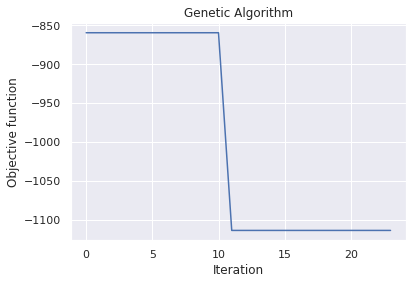


 The best solution found:                                                                           
 [ 32.29529101  57.05437385  84.39350229 123.04731985]

 Objective function:
 -907.5187377929688


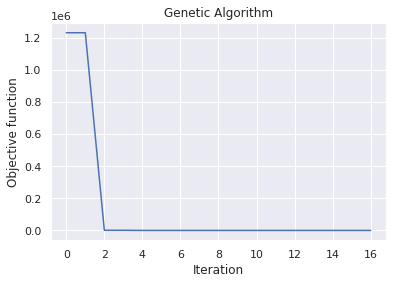


 The best solution found:                                                                           
 [ 35.80728044  47.16742471  89.74067471 122.20917761]

 Objective function:
 -960.7075805664062


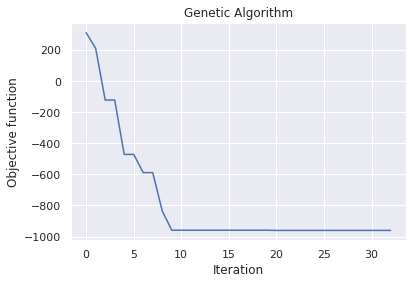


 The best solution found:                                                                           
 [ 11.89958555  58.66473328 102.46198752 122.17650443]

 Objective function:
 -1406.355712890625


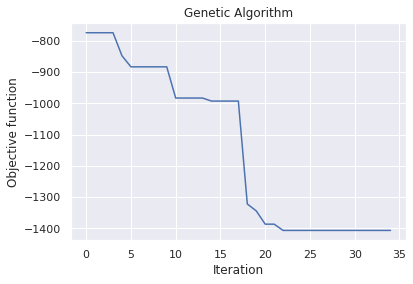


 The best solution found:                                                                           
 [ 24.74807544  59.02837496 103.38502414 118.22245034]

 Objective function:
 -1339.1636962890625


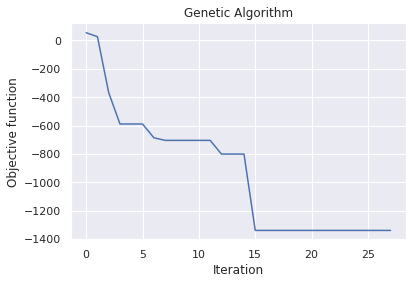


 The best solution found:                                                                           
 [ 27.26343292 152.73568231  64.52657867 122.5322894 ]

 Objective function:
 -706.3001098632812


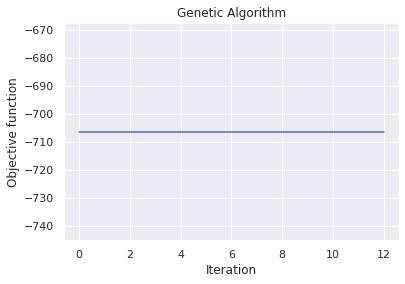


 The best solution found:                                                                           
 [ 28.97202364  48.74622601 115.82680187  38.0387828 ]

 Objective function:
 -820.1421508789062


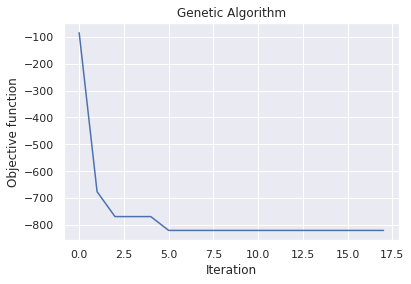


 The best solution found:                                                                           
 [16.10010415 51.46219493 63.98557869 95.29461342]

 Objective function:
 -1041.681396484375


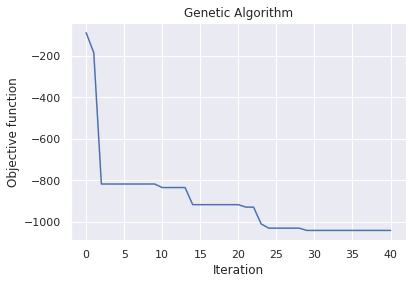

 The best solution found:                                                                           
 [ 28.43930845 109.96242198  85.61975496  44.58466679]

 Objective function:
 -917.9998168945312


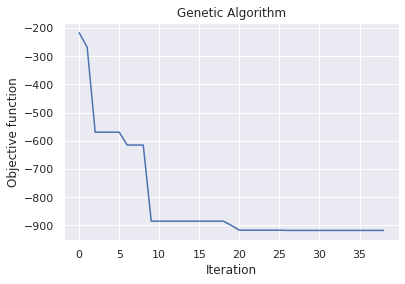


 The best solution found:                                                                           
 [ 43.32974125  50.10715051 121.62613992  75.12311808]

 Objective function:
 -1183.8912353515625


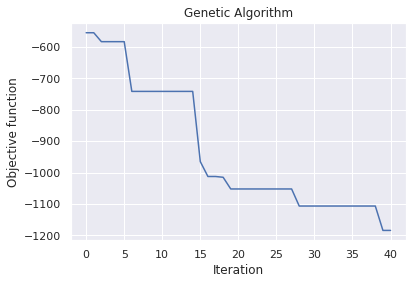

 The best solution found:                                                                           
 [ 19.13281323  44.10637882 135.51461184 111.11357424]

 Objective function:
 -1057.1527099609375


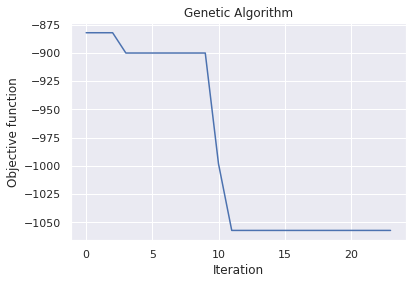


 The best solution found:                                                                           
 [ 42.97865343 109.63424228 128.10354452 121.10556297]

 Objective function:
 -618.2600708007812


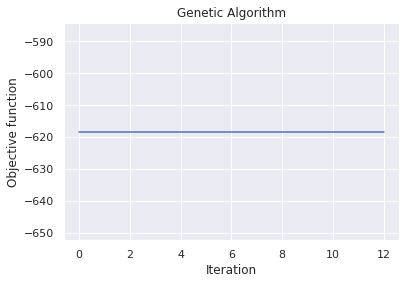


 The best solution found:                                                                           
 [12.98161296 36.6153992  91.39167262 77.81023061]

 Objective function:
 -1139.2706298828125


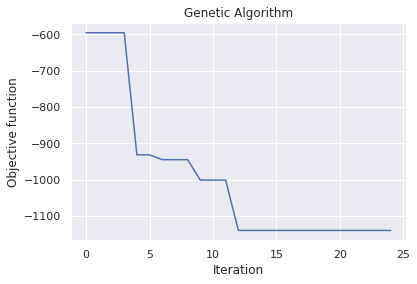


 The best solution found:                                                                           
 [ 34.79111868  45.14526038 103.54689582  57.25679362]

 Objective function:
 -1354.4136962890625


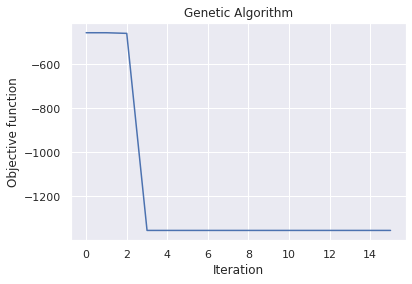


 The best solution found:                                                                           
 [ 41.90338685  56.93051473 101.73307886  96.00479258]

 Objective function:
 -1456.4246826171875


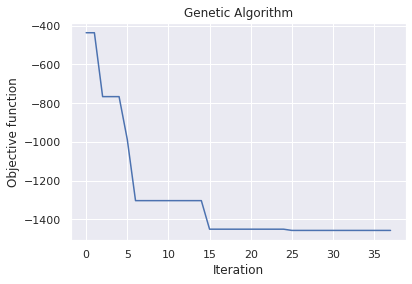


 The best solution found:                                                                           
 [25.64544881 48.25151216 87.33347373 76.54248713]

 Objective function:
 -1529.6751708984375


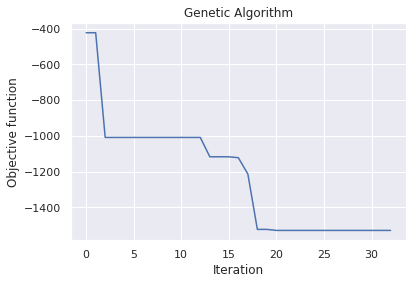


 The best solution found:                                                                           
 [35.97177752 50.10613194 89.28687933 97.25551136]

 Objective function:
 -1087.1337890625


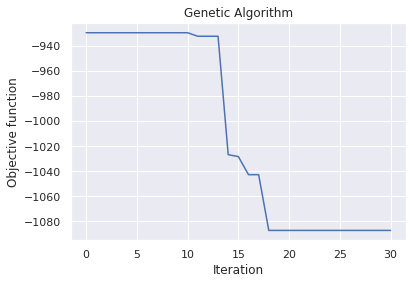


 The best solution found:                                                                           
 [19.77409187 49.17445494 92.35026113 78.92762386]

 Objective function:
 -1127.884521484375


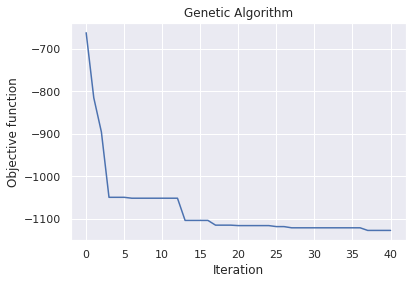

 The best solution found:                                                                           
 [ 31.72247705  49.64050501 101.82281251 101.74571153]

 Objective function:
 -1466.5439453125


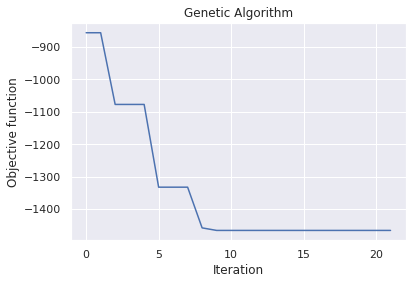


 The best solution found:                                                                           
 [42.66172313 36.71062242 97.38994673 95.18539769]

 Objective function:
 -1095.1661376953125


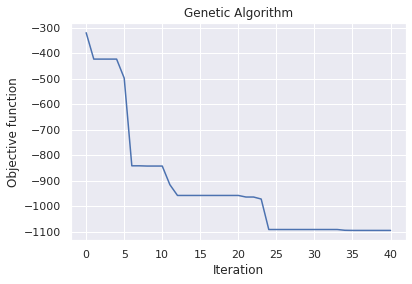

 The best solution found:                                                                           
 [ 11.46400615  46.51450495 103.30509506  78.96996873]

 Objective function:
 -1501.41357421875


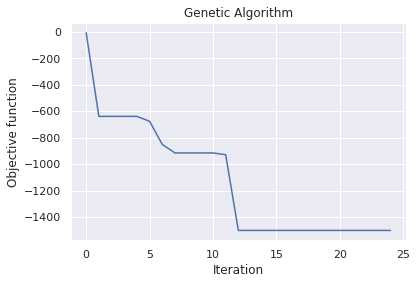


 The best solution found:                                                                           
 [ 33.20305299  48.75570149 102.20068719 104.02992615]

 Objective function:
 -1472.3409423828125


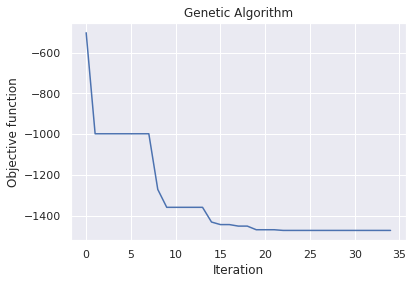


 The best solution found:                                                                           
 [43.56734153 44.18249499 92.19584156 74.35312639]

 Objective function:
 -1063.2366943359375


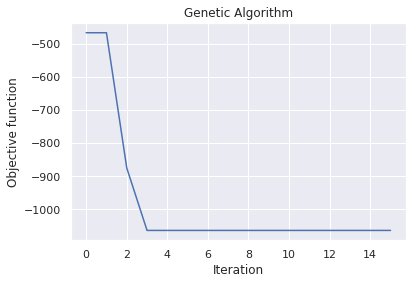


 The best solution found:                                                                           
 [ 22.09012369  58.31950103 102.75688833  77.41119141]

 Objective function:
 -1580.5826416015625


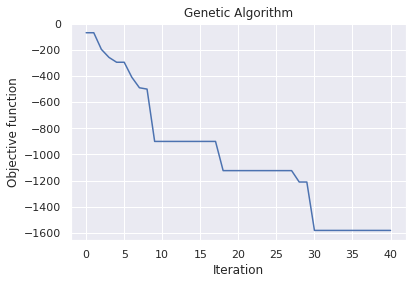

 The best solution found:                                                                           
 [ 21.12712598  46.02094059 101.66991472  73.15742831]

 Objective function:
 -1462.5479736328125


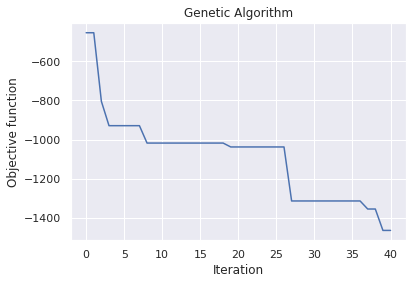

 The best solution found:                                                                           
 [ 18.56898638 152.96537499 102.23006253  41.12580361]

 Objective function:
 -969.6203002929688


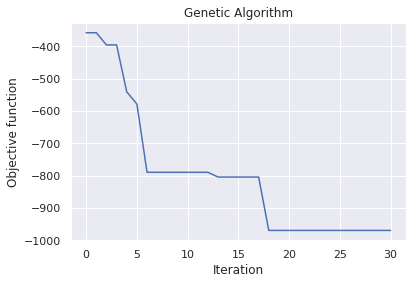


 The best solution found:                                                                           
 [38.06926501 40.59869149 64.87581833 77.82972145]

 Objective function:
 -995.9053344726562


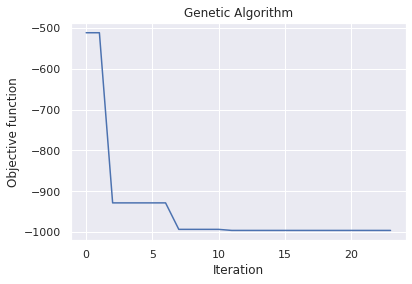


 The best solution found:                                                                           
 [27.08892323 50.78735743 91.94397941 71.69553972]

 Objective function:
 -1073.935302734375


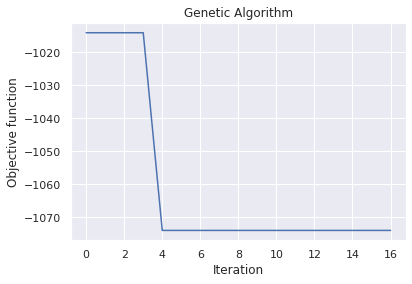


 The best solution found:                                                                           
 [ 34.23790566  50.64463289 101.62800115  74.67258289]

 Objective function:
 -1578.9127197265625


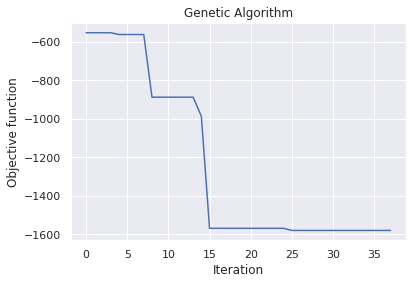


 The best solution found:                                                                           
 [ 42.50513417  42.04831585 105.98046853  94.41194441]

 Objective function:
 -892.4633178710938


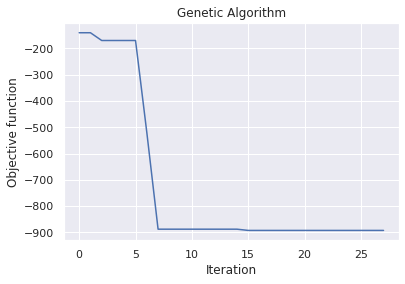


 The best solution found:                                                                           
 [40.6187469  32.08011589 86.06873903 95.00610242]

 Objective function:
 -1296.3970947265625


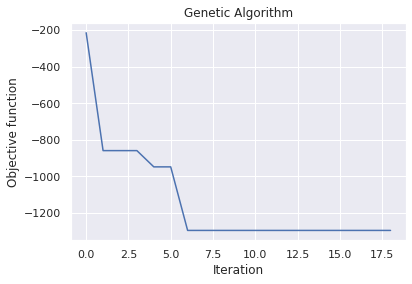


 The best solution found:                                                                           
 [ 43.06805615  51.72231248 107.18019704  96.76746529]

 Objective function:
 -915.1547241210938


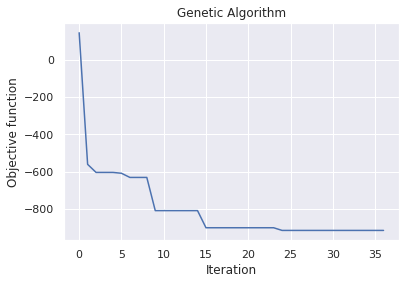


 The best solution found:                                                                           
 [ 26.05138961  50.17572467 128.31719778 114.551853  ]

 Objective function:
 -1118.674072265625


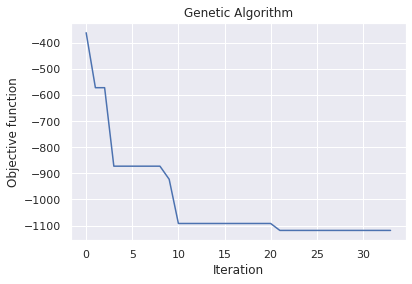


 The best solution found:                                                                           
 [31.67819023 51.21752528 82.69026881 76.69714456]

 Objective function:
 -1285.1783447265625


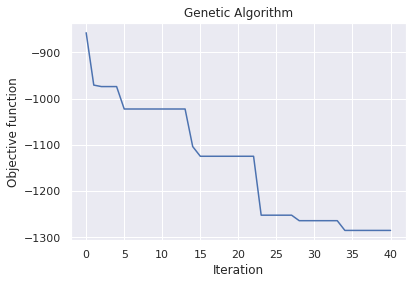

 The best solution found:                                                                           
 [19.34953432 58.69474269 50.37035228 46.06102089]

 Objective function:
 -810.1438598632812


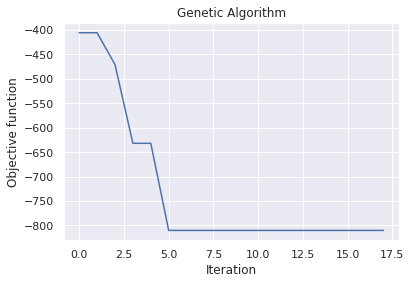


 The best solution found:                                                                           
 [ 15.9961547   50.16248676  85.41159853 122.99166719]

 Objective function:
 -1163.359619140625


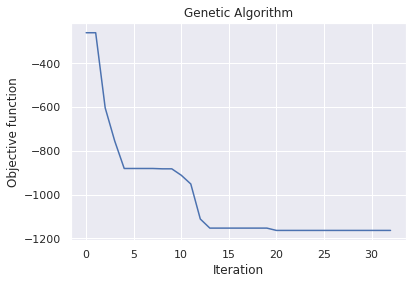


 The best solution found:                                                                           
 [13.91142091 51.13556973 87.0172086  82.92985597]

 Objective function:
 -1344.6534423828125


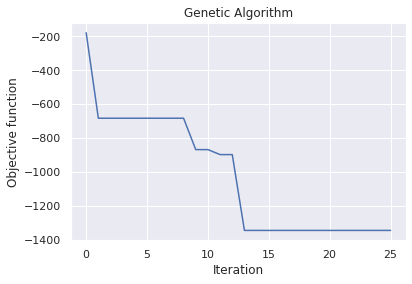


 The best solution found:                                                                           
 [ 45.747623    34.05449079  86.48302227 124.20155072]

 Objective function:
 -1190.5797119140625


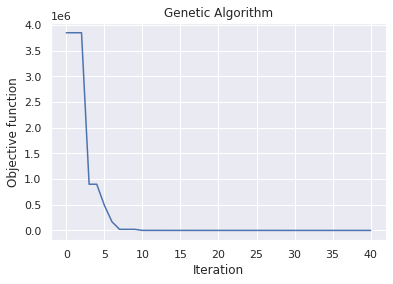


 The best solution found:                                                                           
 [ 22.87158221   4.11334866 101.31504533  76.33126486]

 Objective function:
 -1258.229248046875


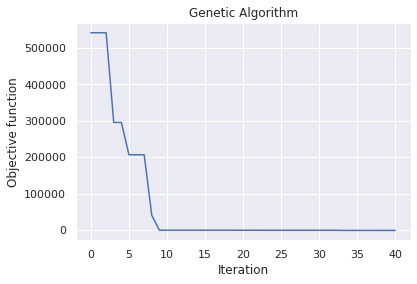

 The best solution found:                                                                           
 [41.17984494 13.99958126 86.98686683 77.3112216 ]

 Objective function:
 -1073.247802734375


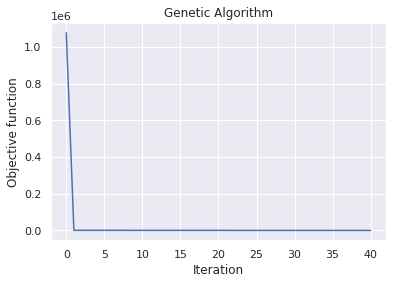

 The best solution found:                                                                           
 [ 27.51150468  35.9087549   88.15292138 169.78011033]

 Objective function:
 -426.2663879394531


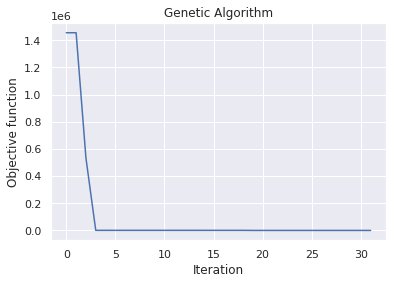


 The best solution found:                                                                           
 [ 21.81493613  35.79999876 103.25491009 124.78350623]

 Objective function:
 -1355.597412109375


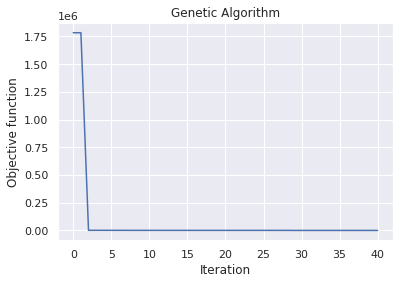

 The best solution found:                                                                           
 [ 32.56186448  85.88118563 101.33672779  78.80984639]

 Objective function:
 -1249.369873046875


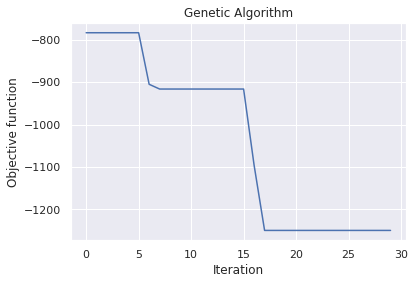


 The best solution found:                                                                           
 [ 35.20820197  49.23691429 102.04024786  94.57171126]

 Objective function:
 -1528.218505859375


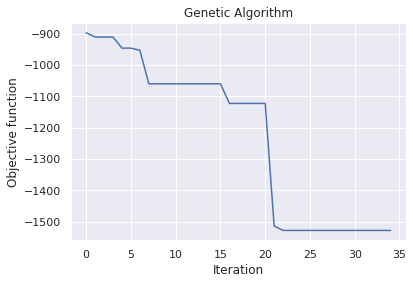


 The best solution found:                                                                           
 [ 11.15108787  50.27756215 139.87508922 112.94788537]

 Objective function:
 -1089.7921142578125


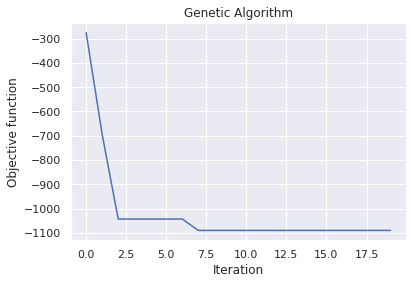


 The best solution found:                                                                           
 [11.51960448 46.16009511 97.3448445  83.72794147]

 Objective function:
 -1038.86083984375


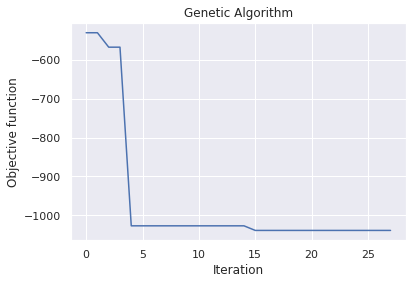


 The best solution found:                                                                           
 [ 25.87876246  29.37669752  86.79400614 118.3188088 ]

 Objective function:
 -1066.7835693359375


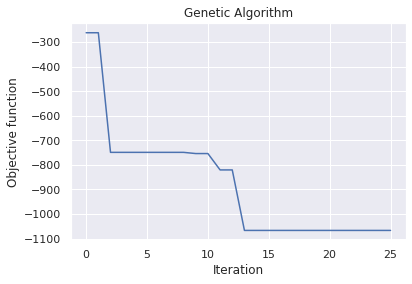


 The best solution found:                                                                           
 [ 26.30011658   5.39961474 100.49832323  77.01548079]

 Objective function:
 -939.0285034179688


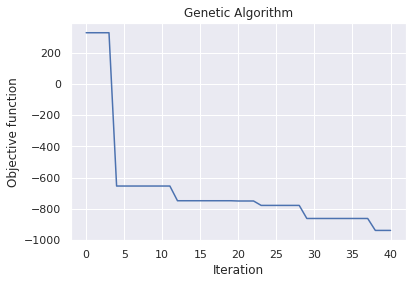

 The best solution found:                                                                           
 [ 39.14136002  86.4672036   88.09609671 124.85486083]

 Objective function:
 -1012.9859008789062


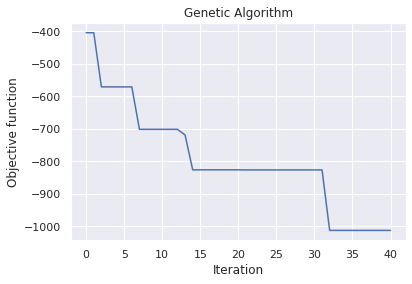

 The best solution found:                                                                           
 [27.50741256 33.71791885 54.95523101 40.83641158]

 Objective function:
 -784.9619750976562


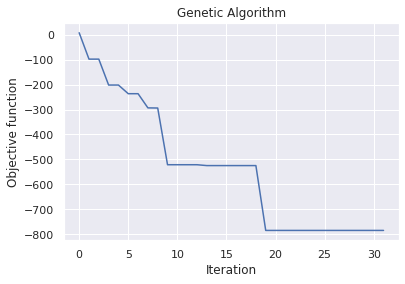


 The best solution found:                                                                           
 [ 11.71409625  49.94049688 127.35248765  77.83322181]

 Objective function:
 -1124.5831298828125


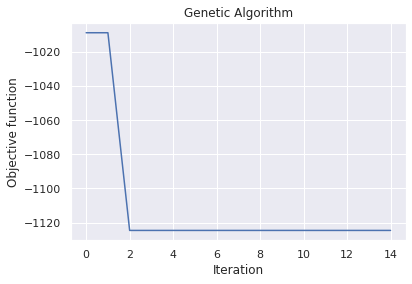


 The best solution found:                                                                           
 [ 25.90713466  50.35683434 132.70914377  30.58196934]

 Objective function:
 -645.1404418945312


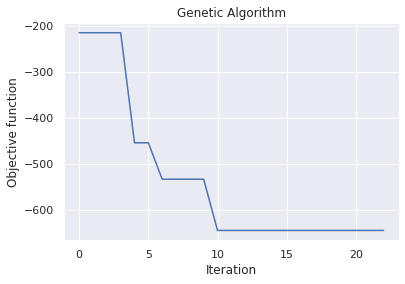


 The best solution found:                                                                           
 [ 16.63688847  42.8589138  103.51273343  40.60954489]

 Objective function:
 -1238.1275634765625


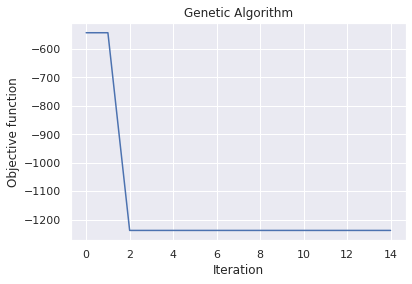


 The best solution found:                                                                           
 [  9.25984261  36.8273249  100.47436715  42.1784618 ]

 Objective function:
 -964.5613403320312


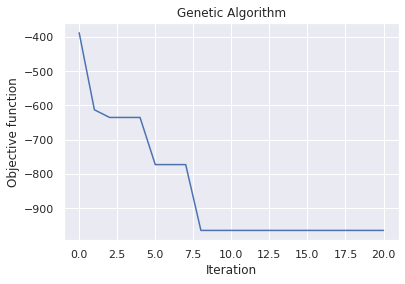


 The best solution found:                                                                           
 [ 27.22197146  42.20356873 134.89163796 102.50578241]

 Objective function:
 -1016.8452758789062


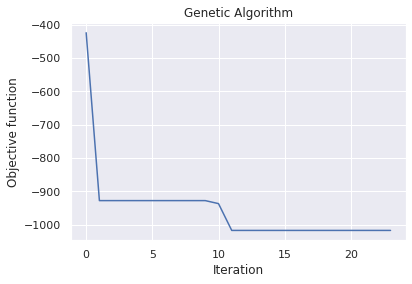


 The best solution found:                                                                           
 [ 24.72690553 107.49199558 128.01508453  75.67515402]

 Objective function:
 -826.4931030273438


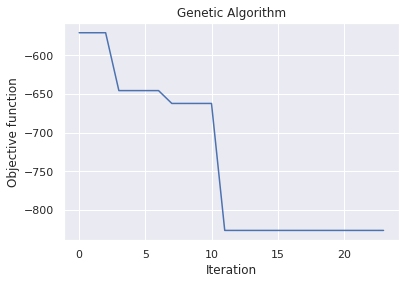


 The best solution found:                                                                           
 [ 13.9232813   49.03224732 126.91187413  96.95047178]

 Objective function:
 -1078.089111328125


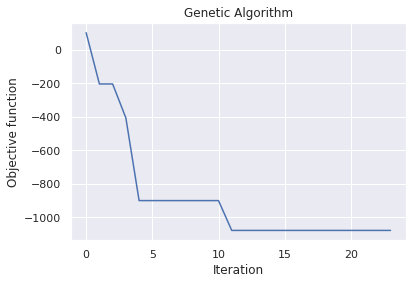


 The best solution found:                                                                           
 [ 37.1673848   43.51502362  89.74657008 125.09744706]

 Objective function:
 -954.6596069335938


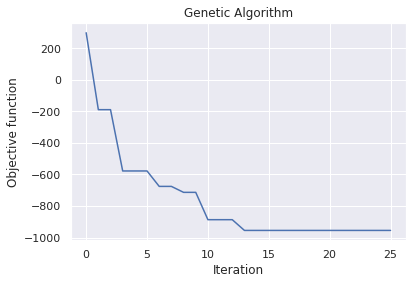


 The best solution found:                                                                           
 [ 12.26312445  48.3603163  261.97025627  84.61582811]

 Objective function:
 -471.1335754394531


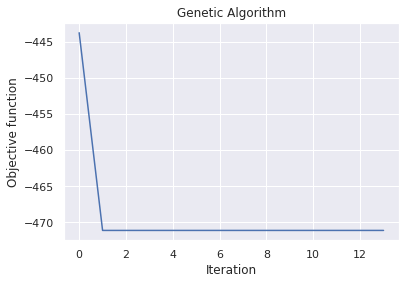


 The best solution found:                                                                           
 [20.27884402 29.00328668 74.50747375 71.34784687]

 Objective function:
 -975.2313842773438


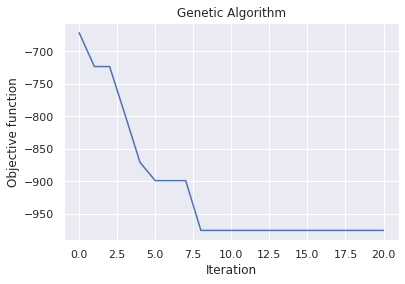


 The best solution found:                                                                           
 [34.6334546  50.74240414 97.95288776 78.83463008]

 Objective function:
 -1156.59521484375


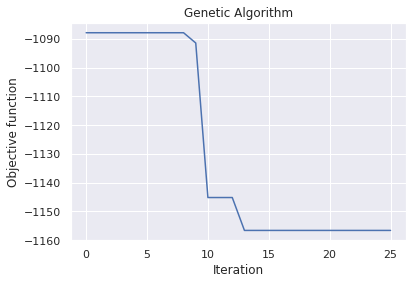


 The best solution found:                                                                           
 [26.4781553  54.96098736 91.6080765  76.90846416]

 Objective function:
 -1202.3787841796875


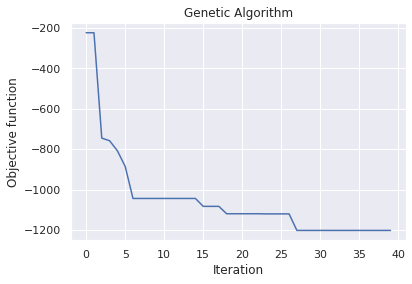


 The best solution found:                                                                           
 [16.82275317 46.79737487 69.39304119 97.03352754]

 Objective function:
 -928.1051635742188


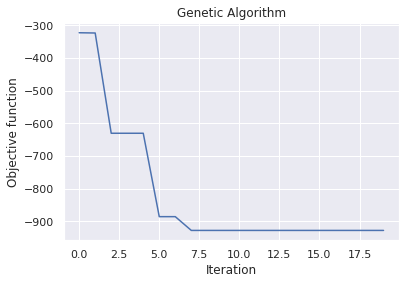


 The best solution found:                                                                           
 [ 29.00901702  58.57858146  76.34492491 105.58782018]

 Objective function:
 -844.3678588867188


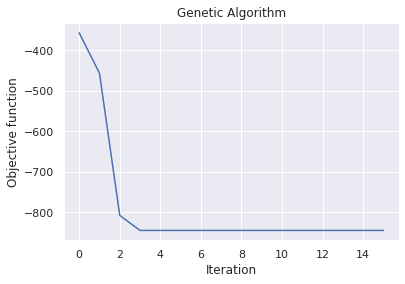


 The best solution found:                                                                           
 [ 30.21728337  56.31253855 101.74015119 105.33322699]

 Objective function:
 -1408.475341796875


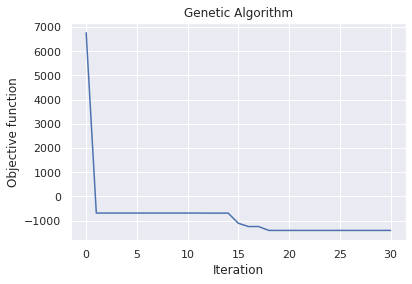


 The best solution found:                                                                           
 [30.84434997 28.02345862 87.30724981 79.18627028]

 Objective function:
 -1366.3995361328125


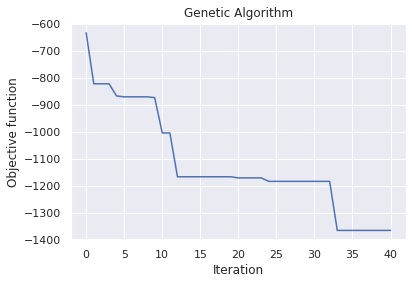

 The best solution found:                                                                           
 [25.81848748 47.07486243 87.24454304 76.44695358]

 Objective function:
 -1523.9246826171875


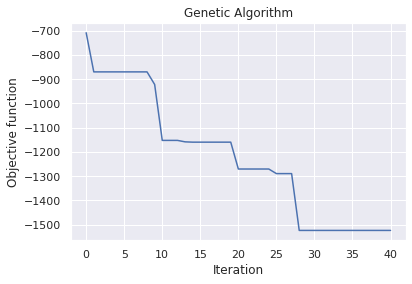


 The best solution found:                                                                           
 [15.46448028 49.33383826 87.24428216 76.52188291]

 Objective function:
 -1532.8546142578125


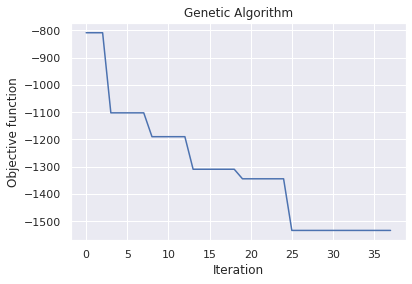


 The best solution found:                                                                           
 [37.71573504 50.53115219 51.27800155 76.93279233]

 Objective function:
 -1130.131591796875


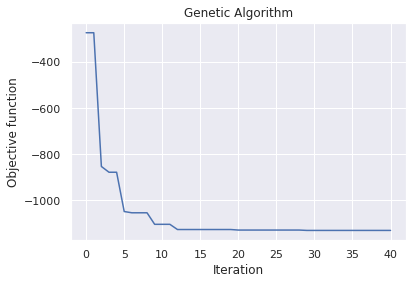

 The best solution found:                                                                           
 [20.95183343  4.35313812 48.0658064  95.00771208]

 Objective function:
 -748.5131225585938


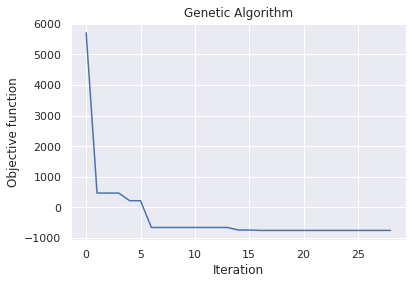


 The best solution found:                                                                           
 [ 21.05539692   2.16266797 101.64745348  77.46426073]

 Objective function:
 -1266.990234375


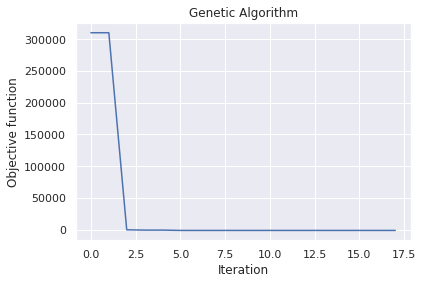


 The best solution found:                                                                           
 [ 36.17344124  36.48067476 107.52379933 102.80633612]

 Objective function:
 -908.8336791992188


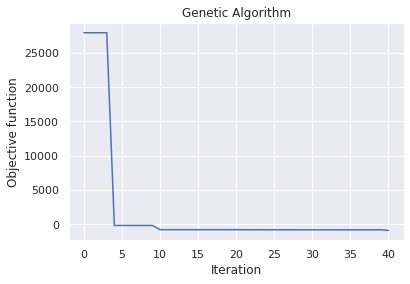

 The best solution found:                                                                           
 [ 10.33304156  36.00608966  87.35974427 122.1021214 ]

 Objective function:
 -1184.5992431640625


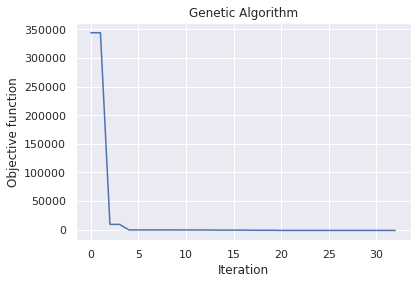


 The best solution found:                                                                           
 [21.29463189  4.85223003 46.31072606 87.67567944]

 Objective function:
 -666.5403442382812


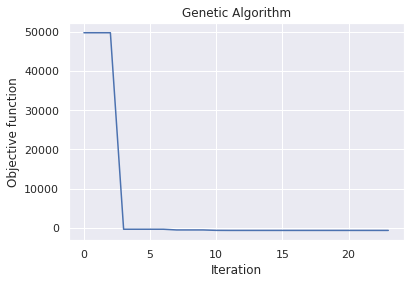


 The best solution found:                                                                           
 [21.51001443  8.97449968 52.33672797 95.30399033]

 Objective function:
 -675.4927368164062


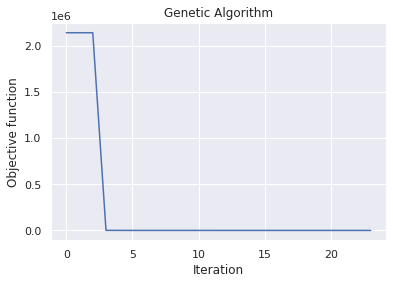


 The best solution found:                                                                           
 [31.51962441 45.16345436 85.67063457 81.28393276]

 Objective function:
 -1299.9957275390625


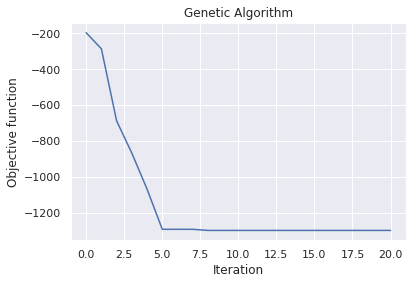


 The best solution found:                                                                           
 [ 38.28860507  27.34841407 102.45520963  77.10114375]

 Objective function:
 -1698.3958740234375


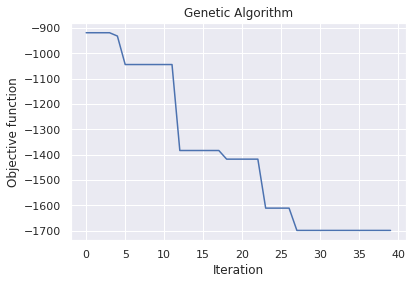


 The best solution found:                                                                           
 [ 26.11202779  36.43440091 106.42336771 115.32344034]

 Objective function:
 -701.8540649414062


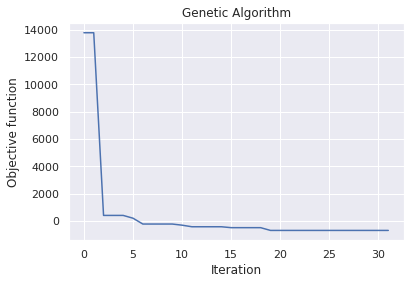


 The best solution found:                                                                           
 [15.65983158 51.56219672 81.09552614 96.03801128]

 Objective function:
 -1074.390380859375


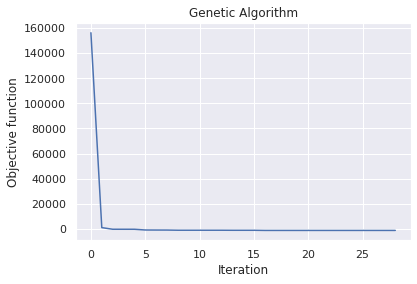


 The best solution found:                                                                           
 [ 18.4398618   54.61048095 103.03281507 109.61343852]

 Objective function:
 -1297.1456298828125


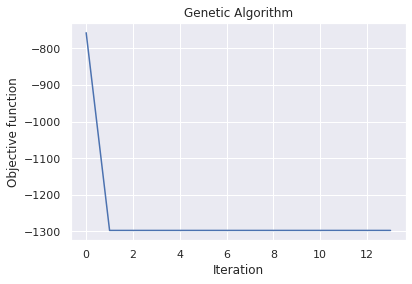


 The best solution found:                                                                           
 [ 35.87678315  47.62863569  85.86499317 124.75967247]

 Objective function:
 -1233.3790283203125


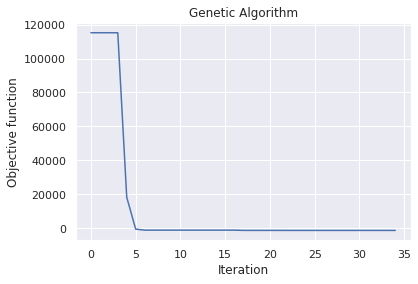


 The best solution found:                                                                           
 [34.96471364 53.69040356 87.14504583 76.80761595]

 Objective function:
 -1470.5731201171875


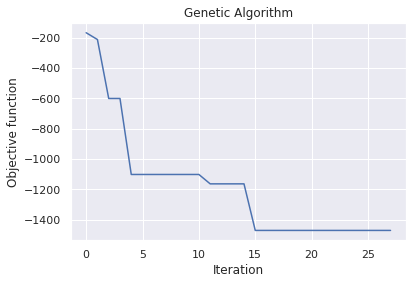


 The best solution found:                                                                           
 [17.20167632 50.27895213 87.15076143 76.81246433]

 Objective function:
 -1535.3280029296875


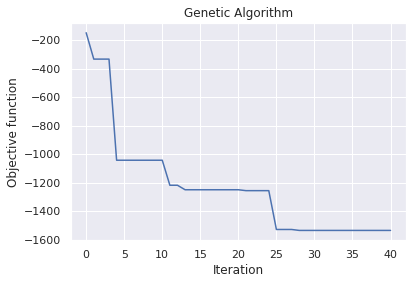


 The best solution found:                                                                           
 [ 36.64604148  44.97893203 114.70614438 109.55956843]

 Objective function:
 -1044.3875732421875


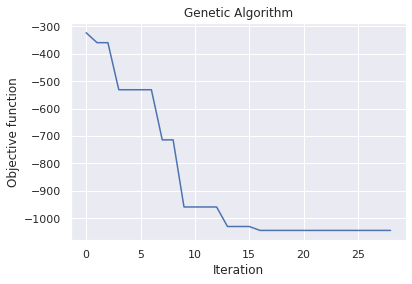


 The best solution found:                                                                           
 [ 21.18583037 150.92123315  74.03196741 124.44468005]

 Objective function:
 -790.9619750976562


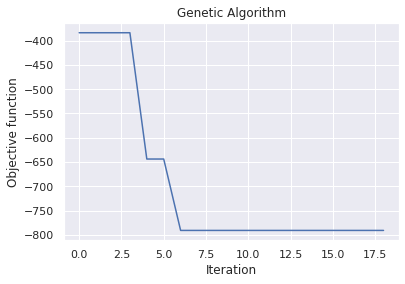


 The best solution found:                                                                           
 [ 36.57936803  30.29949004  86.16176137 104.60275057]

 Objective function:
 -1209.325927734375


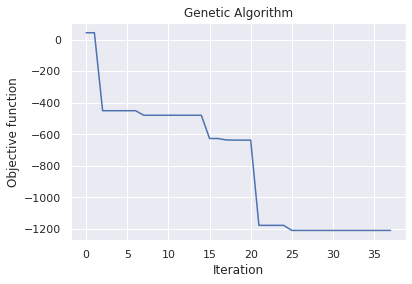


 The best solution found:                                                                           
 [45.13869469  3.38050794 42.70752997 85.31051444]

 Objective function:
 -675.2476196289062


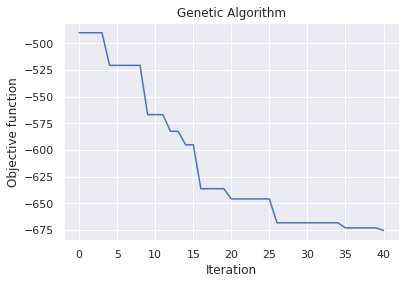

 The best solution found:                                                                           
 [35.31391602 34.08614806 86.98087087 95.96914791]

 Objective function:
 -1400.9599609375


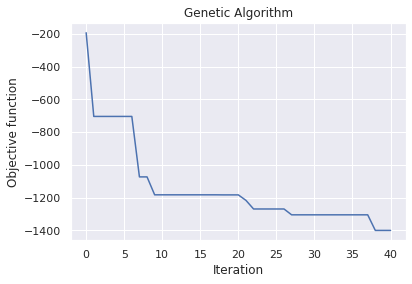

 The best solution found:                                                                           
 [ 12.43251999 122.34584847  45.71496995  48.24194392]

 Objective function:
 -691.7097778320312


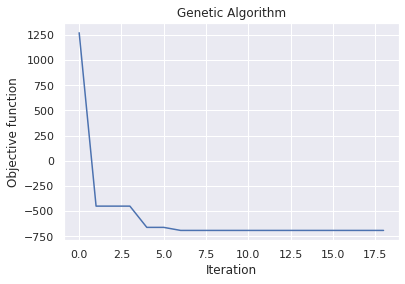


 The best solution found:                                                                           
 [19.81927863 43.31278608 82.32182048 94.12905683]

 Objective function:
 -1116.359619140625


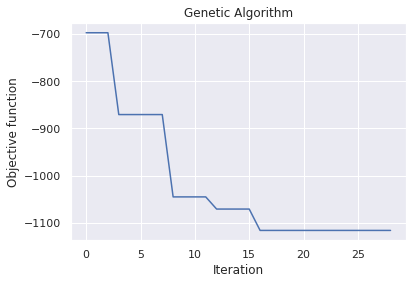


 The best solution found:                                                                           
 [37.47788235 37.29448323 91.92616057 93.21721599]

 Objective function:
 -1074.1925048828125


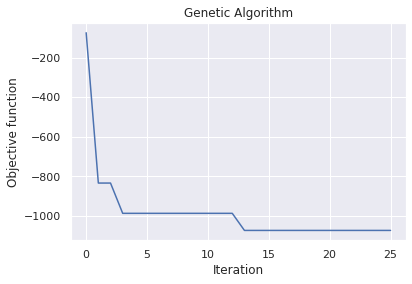


 The best solution found:                                                                           
 [ 25.45162597  46.72320833 102.97695551 116.62244191]

 Objective function:
 -1315.890869140625


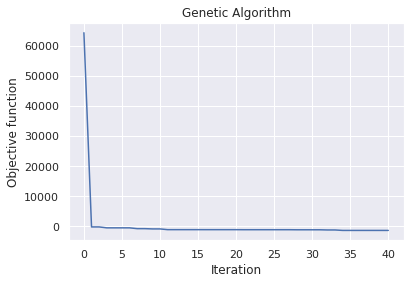

||||||||||||||||||||||||__________________________ 47.5% GA is running...

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 The best solution found:                                                                           
 [ 28.457849    33.59959926 102.51893149  81.61414451]

 Objective function:
 -1435.4835205078125


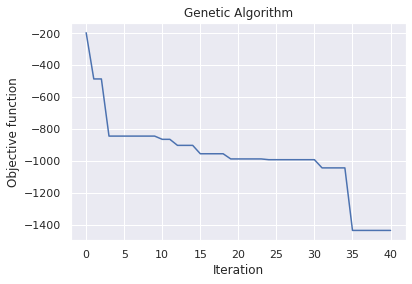

 The best solution found:                                                                           
 [26.9438839  26.38963601 83.7459967  48.92196095]

 Objective function:
 -1017.2012329101562


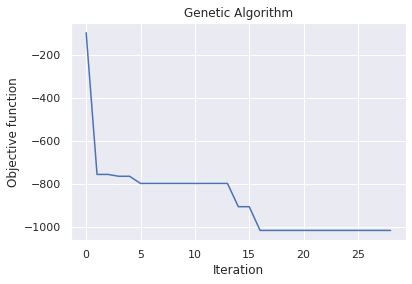


 The best solution found:                                                                           
 [ 43.02173257  47.85759777 102.58773965 113.14389668]

 Objective function:
 -1535.1893310546875


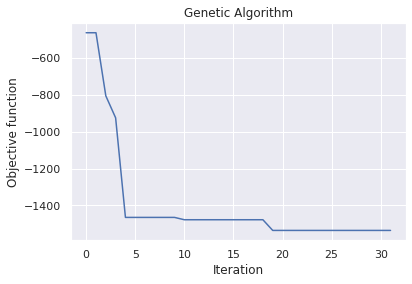


 The best solution found:                                                                           
 [ 25.52334028  47.36176121  82.64267604 111.53589718]

 Objective function:
 -1029.3565673828125


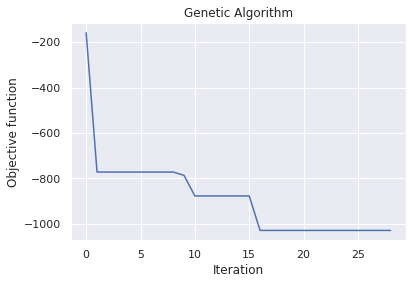


 The best solution found:                                                                           
 [41.80300837 43.80636657 85.38149004 90.23504933]

 Objective function:
 -1243.5003662109375


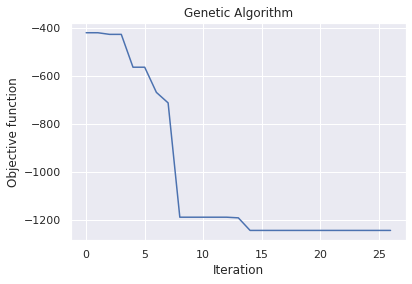


 The best solution found:                                                                           
 [ 22.65998459 153.14240574  45.76601967  74.88919027]

 Objective function:
 -752.6311645507812


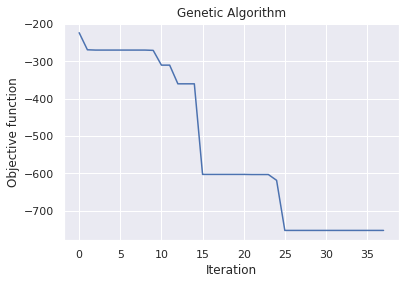


 The best solution found:                                                                           
 [ 13.42522397  33.8730327   85.28354843 118.04144684]

 Objective function:
 -1127.335205078125


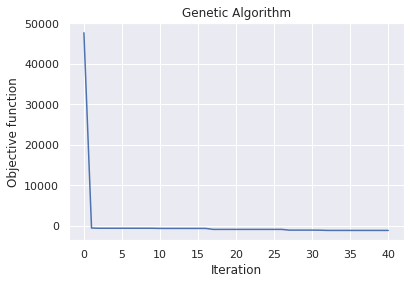

 The best solution found:                                                                           
 [ 14.74125902  50.10620292  86.06327692 123.53079888]

 Objective function:
 -1219.63720703125


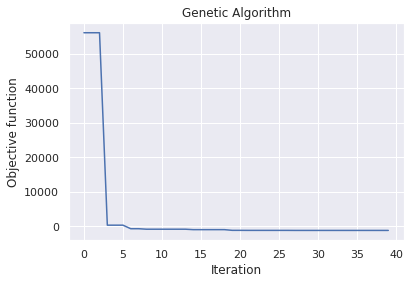


 The best solution found:                                                                           
 [35.92655269 16.09051055 87.46479884 76.73387657]

 Objective function:
 -1134.2979736328125


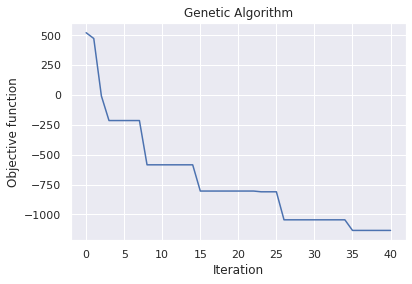

 The best solution found:                                                                           
 [ 25.59547664  26.91524544  91.56310255 107.02033429]

 Objective function:
 -935.8760375976562


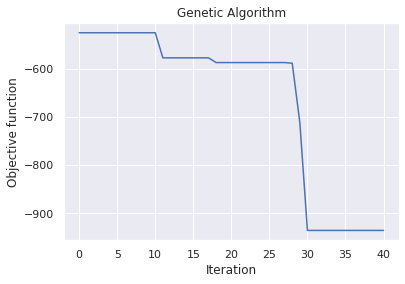

 The best solution found:                                                                           
 [ 23.25647876  33.45362141  88.58643386 123.66992   ]

 Objective function:
 -819.6940307617188


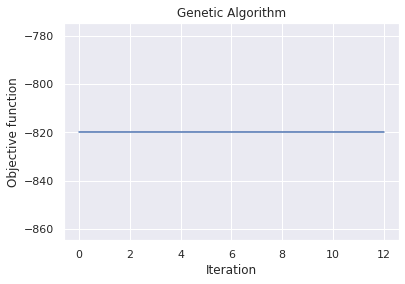


 The best solution found:                                                                           
 [  9.17750792  54.60111138 101.94519252  45.07302338]

 Objective function:
 -1302.0916748046875


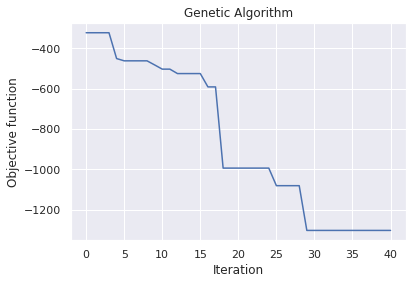

 The best solution found:                                                                           
 [  8.14224316   6.15314445 103.10261265  82.86267057]

 Objective function:
 -1086.891357421875


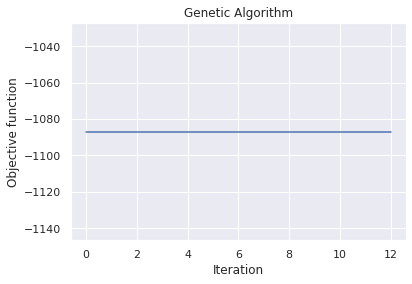


 The best solution found:                                                                           
 [19.76087186 53.53632139 65.43903735 72.13840543]

 Objective function:
 -894.9454956054688


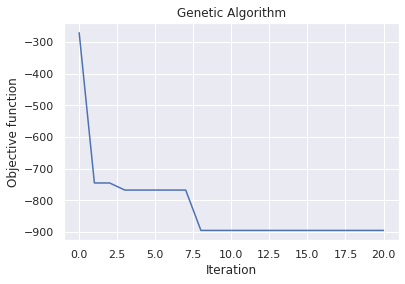


 The best solution found:                                                                           
 [24.38962066 36.06024659 86.59076483 76.74512707]

 Objective function:
 -1530.2672119140625


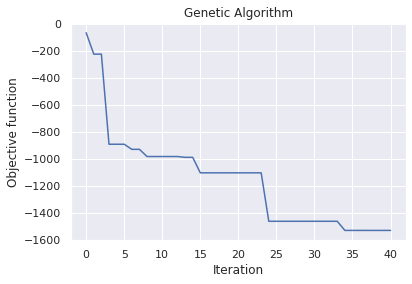

 The best solution found:                                                                           
 [24.44622273 33.95775669 86.86342054 93.41887235]

 Objective function:
 -1345.8160400390625


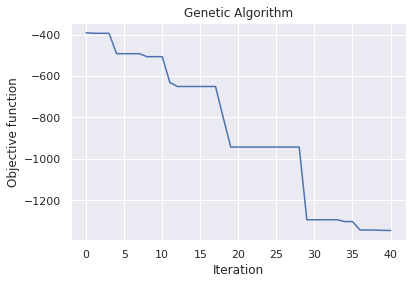

 The best solution found:                                                                           
 [ 13.42404278  49.27645562  88.30329924 113.77616963]

 Objective function:
 -1061.350830078125


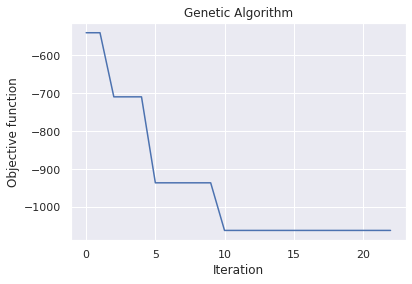


 The best solution found:                                                                           
 [ 23.95254827  51.51791118  85.70637415 105.32463553]

 Objective function:
 -1292.7098388671875


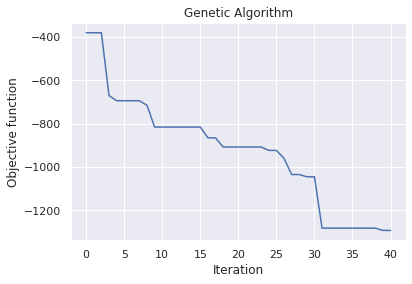

 The best solution found:                                                                           
 [ 21.84931982  44.99291128 102.31058724 121.53353245]

 Objective function:
 -1397.653564453125


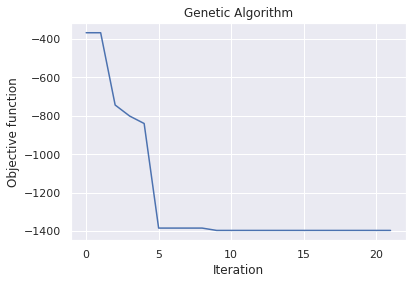


 The best solution found:                                                                           
 [ 21.5352862   54.62771083 101.84707057 106.97600378]

 Objective function:
 -1346.8612060546875


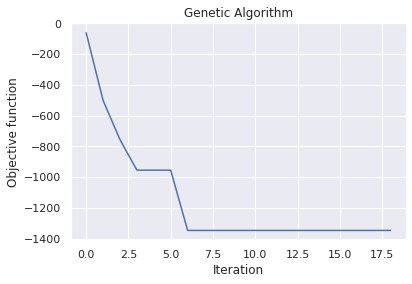


 The best solution found:                                                                           
 [25.95042419 27.78003965 89.20311085 95.00921929]

 Objective function:
 -1083.1842041015625


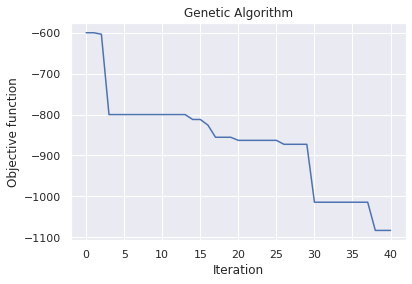

 The best solution found:                                                                           
 [ 15.9933579   23.86781678 101.11949761  42.74317274]

 Objective function:
 -1130.67822265625


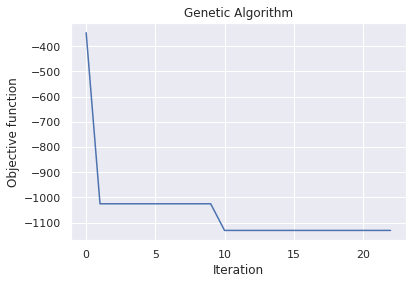


 The best solution found:                                                                           
 [ 40.36451238  53.37189949 115.01751316  77.00141031]

 Objective function:
 -1183.0928955078125


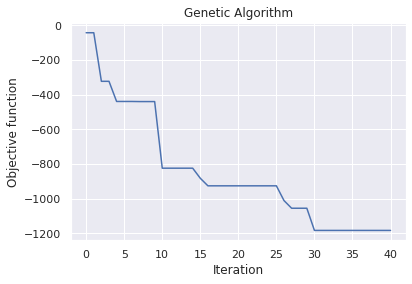

 The best solution found:                                                                           
 [12.65495776 49.86177972 85.75693667 39.88824264]

 Objective function:
 -1123.1107177734375


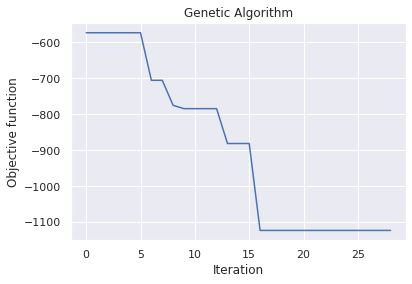


 The best solution found:                                                                           
 [34.50621674 51.11120333 63.75306407 73.52877862]

 Objective function:
 -949.6162719726562


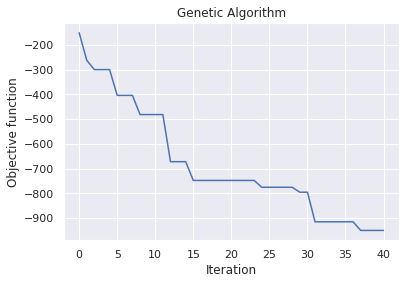

 The best solution found:                                                                           
 [31.84744129 53.89698302 81.83204141 76.127695  ]

 Objective function:
 -1222.282958984375


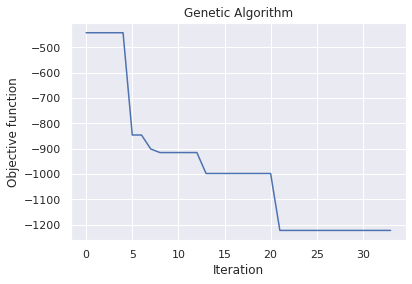


 The best solution found:                                                                           
 [ 22.10236629  50.83575878 102.38647536 104.90350495]

 Objective function:
 -1514.648193359375


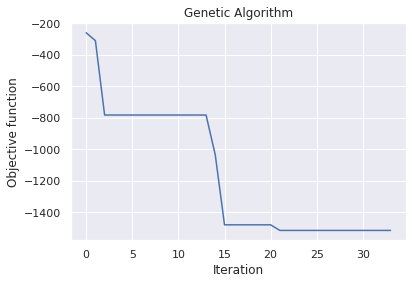


 The best solution found:                                                                           
 [20.10557053 51.06392602 86.89644673 94.64905344]

 Objective function:
 -1411.6474609375


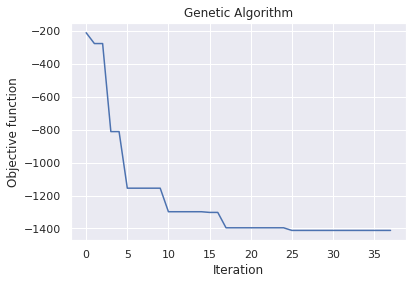


 The best solution found:                                                                           
 [31.71720823 37.420925   86.8975561  76.60964444]

 Objective function:
 -1525.47607421875


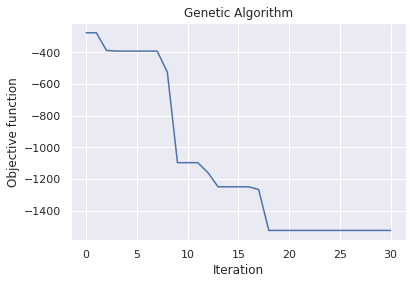


 The best solution found:                                                                           
 [28.89441603 48.25533325 85.79824073 95.69453906]

 Objective function:
 -1386.6346435546875


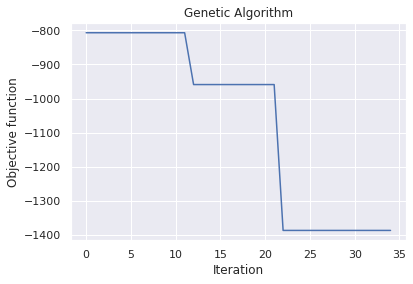

In [50]:
prescription = {i:{"variable":None, "yield_co2_ratio": None, "yield_pred": None, "co2_pred":None} for i in range(subset_df.shape[0])}
for index, row in subset_df.iterrows():
    context = row['Soil_Organic_Matter']
    predictor = loaded_models_hybrids[row['Hybrid']].predictor
    planned_yield = row['Planned_Yield_kg_per_ha']
    fun_to_optimize = partial(yield_co2_ratio, predictor, planned_yield, context)

    model=ga(function=fun_to_optimize,dimension=4,variable_type='real',variable_boundaries=varbound,algorithm_parameters=algorithm_param)
    model.run()
    
    prescription[index]['variable'] = model.output_dict['variable']
    prescription[index]['yield_co2_ratio'] = model.output_dict['function']
    
    full_features = np.hstack([context,model.output_dict['variable']]).reshape([1,-1])
    
    prescription[index]['yield_pred'] = predict_yield_old(full_features)
    prescription[index]['co2_pred'] = predict_co2(full_features)

In [38]:
prescription
loaded_prescriptor_data = prescription

In [51]:
import pickle
filehandler = open("prescription_bound_co2_per_yield_total_hybrid.pkl","wb")
pickle.dump(prescription,filehandler)

#### Load the saved prescriptor

In [61]:
loaded_prescriptor_data = pickle.load(open('/mnt/CO2Pred/prescription_bound_co2_per_yield_total_hybrid.pkl', 'rb'))

In [62]:
loaded_prescriptor_data[0]

{'variable': array([ 33.25718898,  92.42335404,  85.71380456, 126.38289028]),
 'yield_co2_ratio': -827.5773315429688,
 'yield_pred': array([[4465.4194]], dtype=float32),
 'co2_pred': array([[-827.57733]], dtype=float32)}

In [63]:
co2_preds, yield_preds, application_dos, nitrogen, phosphorus, potassium = [], [], [], [], [], []
for i in range(len(loaded_prescriptor_data)):
    co2_preds.append(loaded_prescriptor_data[i]['co2_pred'][0][0])
    yield_preds.append(loaded_prescriptor_data[i]['yield_pred'][0][0])
    application_dos.append(loaded_prescriptor_data[i]['variable'][0])
    nitrogen.append(loaded_prescriptor_data[i]['variable'][1])
    phosphorus.append(loaded_prescriptor_data[i]['variable'][2])
    potassium.append(loaded_prescriptor_data[i]['variable'][3])


In [87]:
palette = iter(sns.husl_palette(3))

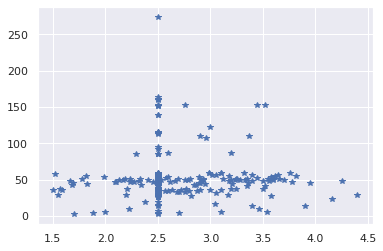

In [83]:
plt.plot(subset_df['Soil_Organic_Matter'], nitrogen, '*')
plt.show()

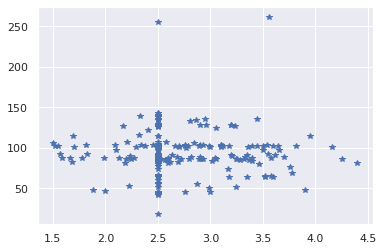

In [65]:
plt.plot(subset_df['Soil_Organic_Matter'], phosphorus, '*')
plt.show()

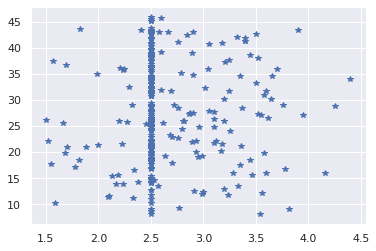

In [66]:
plt.plot(subset_df['Soil_Organic_Matter'], application_dos, '*')
plt.show()

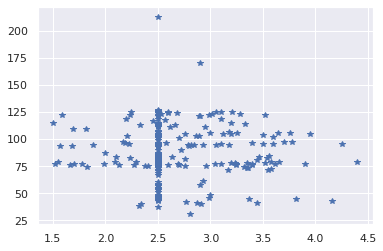

In [67]:
plt.plot(subset_df['Soil_Organic_Matter'], potassium, '*')
plt.show()

In [68]:
subset_df['Total_N_pred'] = nitrogen
subset_df['Total_P_pred'] = phosphorus
subset_df['Total_K_pred'] = potassium
subset_df['Application_dos_pred'] = application_dos

In [ ]:
df.head()

### Observe the prescription vs the actual data for the controlled variables

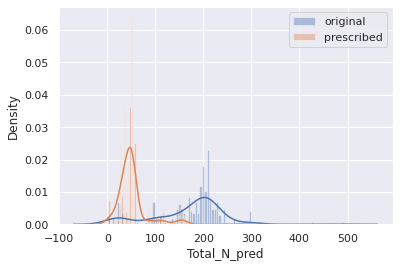

In [84]:
n_bins = 100
fig, ax = plt.subplots(1,1)
sns.distplot(subset_df.Total_N, bins = n_bins, label = "original")
sns.distplot(subset_df.Total_N_pred, bins = n_bins, label = "prescribed")
ax.legend()
# fig.savefig("/mnt/CO2Pred/fig/" + "N_dist.png", format='png', dpi=800)
plt.show()

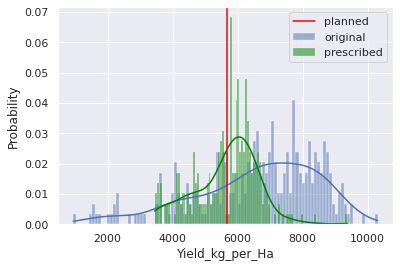

In [95]:
n_bins = 100
fig, ax = plt.subplots(1,1)
sns.histplot(subset_df.Yield_kg_per_Ha, kde = True, bins = n_bins, stat = 'probability', label = "original")
sns.histplot(yield_preds, kde = True, bins = n_bins, stat = 'probability', label = "prescribed", color = "green")
ax.axvline(subset_df.Planned_Yield_kg_per_ha.mean(), color = 'red', label = "planned")

ax.legend()
# fig.savefig("/mnt/CO2Pred/fig/" + "Yield_dist.png", format='png', dpi=800)
plt.show()

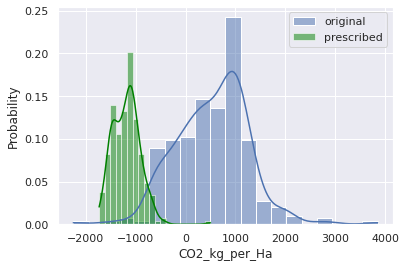

In [75]:
n_bins = 100
fig, ax = plt.subplots(1,1)
sns.histplot(subset_df.CO2_kg_per_Ha, kde = True, label = "original", stat = 'probability')
sns.histplot(co2_preds, kde = True, label = "prescribed", stat = 'probability', color = "green")
ax.legend()
# fig.savefig("/mnt/CO2Pred/fig" + "CO2_dist600.png", format='png', dpi=600)
plt.show()

In [ ]:
# n_bins = 100
# fig, ax = plt.subplots(1,1)
# sns.distplot(co2_original_predicted, bins = n_bins, label = "original")
# sns.distplot(co2_preds, bins = n_bins, label = "prescribed")
# # ax.set_yscale('log')
# ax.legend()
# plt.show()


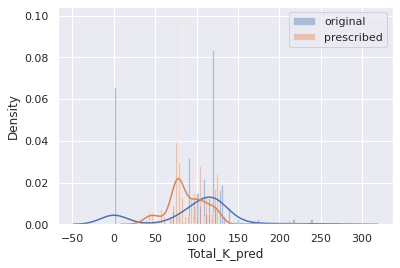

In [76]:
n_bins = 100
fig, ax = plt.subplots(1,1)
sns.distplot(subset_df.Total_K, bins = n_bins, label = "original")
sns.distplot(subset_df.Total_K_pred, bins = n_bins, label = "prescribed")
ax.legend()
# fig.savefig("/mnt/CO2Pred/fig/" + "K_dist.png", format='png', dpi=800)
plt.show()

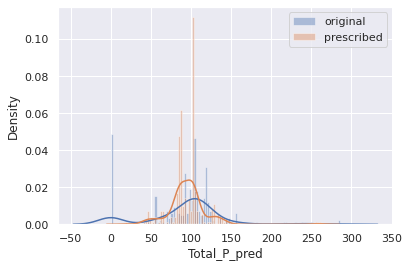

In [77]:
n_bins = 100
fig, ax = plt.subplots(1,1)
sns.distplot(subset_df.Total_P, bins = n_bins, label = "original")
sns.distplot(subset_df.Total_P_pred, bins = n_bins, label = "prescribed")
ax.legend()
# fig.savefig("/mnt/CO2Pred/fig/" + "P_dist.png", format='png', dpi=800)
plt.show()

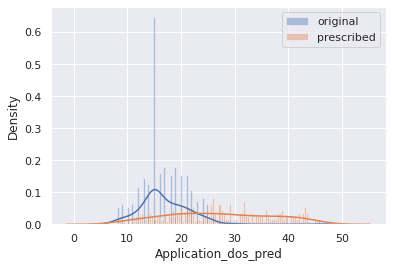

In [78]:
n_bins = 100
fig, ax = plt.subplots(1,1)
sns.distplot(subset_df.Crop_Protection_Application_Doses, bins = n_bins, label = "original")
sns.distplot(subset_df.Application_dos_pred, bins = n_bins, label = "prescribed")
ax.legend()
# fig.savefig("/mnt/CO2Pred/fig/" + "app_dose_dist.png", format='png', dpi=800)
plt.show()

#### Observe the yield and co2 predictions

In [ ]:
sns.distplot(co2_preds)
plt.show()

In [ ]:
sns.distplot(yield_preds)
plt.show()

In [79]:
# Find Pareto front points
pareto_front = []
for i in range(len(co2_preds)):
    is_pareto_point = True
    for j in range(len(co2_preds)):
        if i != j and co2_preds[j] <= co2_preds[i] and yield_preds[j] >= yield_preds[i]:
            is_pareto_point = False
            break
    if is_pareto_point:
        pareto_front.append({"CO_2 (kg/Ha)": co2_preds[i], "Yield (kg/Ha)": yield_preds[i]})

In [80]:
pareto_front = pd.DataFrame(pareto_front)

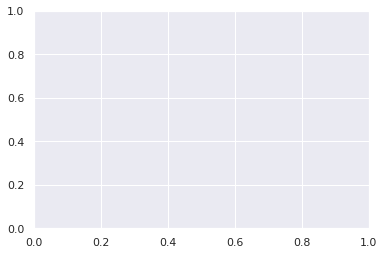

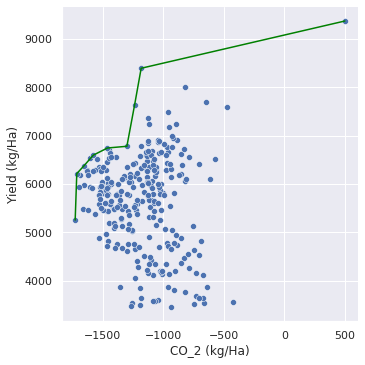

In [81]:
fig, ax = plt.subplots(1,1)
plot = sns.relplot(co2_preds, yield_preds)
plot = sns.lineplot(y = "Yield (kg/Ha)", x = "CO_2 (kg/Ha)", data = pareto_front, color = "green", markers = True)
# fig.savefig("/mnt/CO2Pred/" + "pareto.png", format='png', dpi=800)
plt.show()

fig = plot.get_figure()
# fig.savefig("/mnt/CO2Pred/fig/" + "pareto.png", format='png', dpi=800)

In [ ]:
sns.distplot(df.Soil_Organic_Matter)
plt.show()

In [ ]:
print(df.Total_N.mean())
print(df.Total_N_pred.mean())
print()
print(df.Total_P.mean())
print(df.Total_P_pred.mean())
print()
print(df.Total_K.mean())
print(df.Total_K_pred.mean())
print()
print(df.Crop_Protection_Application_Doses.mean())
print(df.Application_dos_pred.mean())

In [ ]:
# penguins = sns.load_dataset("penguins")

In [ ]:
# penguins

In [ ]:
2